In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

In [61]:
data = pd.read_csv("breast-cancer-wisconsin.data", na_values="?")
cols = data.columns.tolist()

data.drop_duplicates(subset=cols[:-1], inplace=True)

data = data.drop('id', 1)
X = data.drop('Class', axis=1)
y = np.array(data['Class'])
y = np.where(y == 2, -1, 1)

imputer = KNNImputer(n_neighbors=1)
X = imputer.fit_transform(X)

X_train, X_val, y_train_1d, y_val_1d = train_test_split(X, y, test_size=0.1, random_state=42)

y_train = y_train_1d.reshape(-1, 1)
y_val = y_val_1d.reshape(-1, 1)

y_train_onehot = np.array(pd.get_dummies(y_train_1d))
y_val_onehot = np.array(pd.get_dummies(y_val_1d))

data

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2.0,1,1,1,2
695,2,1,1,1,2,1.0,1,1,1,2
696,5,10,10,3,7,3.0,8,10,2,4
697,4,8,6,4,3,4.0,10,6,1,4


In [62]:
def knn_kfolds(X_kf, y_kf, n_folds, n_neighbors, random_state=None):      
    kf = KFold(n_splits=n_folds)
    avg_score = 0
    for train_idx, test_idx in kf.split(X_kf):
        X_train_kf, X_test_kf = X_kf[train_idx], X_kf[test_idx]
        y_train_kf, y_test_kf = y_kf[train_idx], y_kf[test_idx]

        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(X_train_kf, y_train_kf)

        r_squared = model.score(X_test_kf, y_test_kf)
        
        avg_score += r_squared

    avg_score /= n_folds
    
    return avg_score

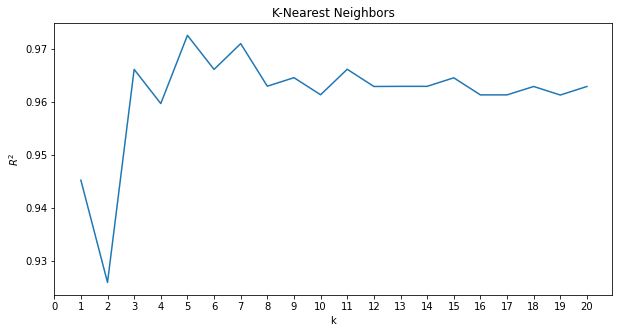

<Figure size 432x288 with 0 Axes>

In [63]:
r_squared = []
for k in range(1,21):
    r2 = knn_kfolds(X_train, y_train_1d, 10, k, random_state=12)
    r_squared.append([k, r2])

r_squared = np.array(r_squared)

idx = list(range(0, 21))
plt.figure(figsize=(10, 5))
plt.plot(r_squared[:,0], r_squared[:,1])
plt.xticks(range(len(idx)),idx)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.title('K-Nearest Neighbors')
plt.show()
plt.savefig('knn.png', dpi=300, bbox_inches='tight')
plt.clf()

In [64]:
maximum = np.max(r_squared[:,1])
index_of_maximum = np.where(r_squared[:,1] == maximum)
print(index_of_maximum[0][0])
knn_kfolds(X_train, y_train_1d, 10, index_of_maximum[0][0] + 1, random_state=4)

4


0.9726062467997952

In [65]:
def decision_tree(X_dt, y_dt, n_folds, depth, random_state=None):      
    kf = KFold(n_splits=n_folds)
    avg_score = 0
    for train_idx, test_idx in kf.split(X_dt):
        X_train_dt, X_test_dt = X_dt[train_idx], X_dt[test_idx]
        y_train_dt, y_test_dt = y_dt[train_idx], y_dt[test_idx]

        model = DecisionTreeClassifier(random_state=0, min_samples_leaf=depth)
        model.fit(X_train_dt, y_train_dt)

        r_squared = model.score(X_test_dt, y_test_dt)
        
        avg_score += r_squared

    avg_score /= n_folds
    
    return avg_score

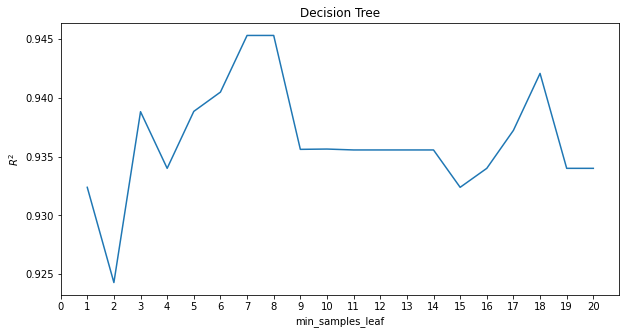

<Figure size 432x288 with 0 Axes>

In [69]:
r_squared = []
for depth in range(1,21):
    r2 = decision_tree(X_train, y_train_1d, 10, depth, random_state=12)
    r_squared.append([depth, r2])

r_squared = np.array(r_squared)

idx = list(range(0, 21))
plt.figure(figsize=(10, 5))
plt.plot(r_squared[:,0], r_squared[:,1])
plt.xticks(range(len(idx)),idx)
plt.xlabel('min_samples_leaf')
plt.ylabel('$R^2$')
plt.title('Decision Tree')
plt.show()
plt.clf()

In [70]:
maximum = np.max(r_squared[:,1])
index_of_maximum = np.where(r_squared[:,1] == maximum)
print(index_of_maximum[0][0] + 1)
decision_tree(X_train, y_train_1d, 10, index_of_maximum[0][0] + 1, random_state=12)

7


0.9452892985151051

In [80]:
def random_forest(X_rf, y_rf, n_folds, depth, random_state=None):      
    kf = KFold(n_splits=n_folds)
    avg_score = 0
    for train_idx, test_idx in kf.split(X_rf):
        X_train_rf, X_test_rf = X_rf[train_idx], X_rf[test_idx]
        y_train_rf, y_test_rf = y_rf[train_idx], y_rf[test_idx]

        model = RandomForestClassifier(random_state=0, n_estimators=depth)
        model.fit(X_train_rf, y_train_rf)

        r_squared = model.score(X_test_rf, y_test_rf)
        
        avg_score += r_squared

    avg_score /= n_folds
    
    return avg_score

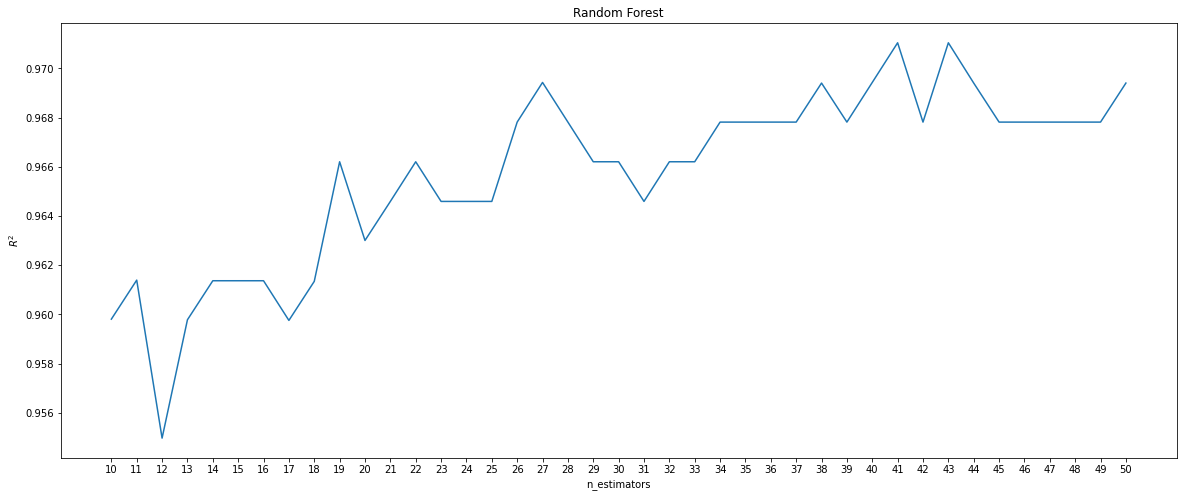

<Figure size 432x288 with 0 Axes>

In [90]:
r_squared = []
for depth in range(10,51):
    r2 = random_forest(X_train, y_train_1d, 10, depth, random_state=12)
    r_squared.append([depth, r2])

r_squared = np.array(r_squared)

idx = list(range(10,51))
plt.figure(figsize=(20, 8))
plt.plot(r_squared[:,0], r_squared[:,1])
plt.xticks(range(10,51),idx)
plt.xlabel('n_estimators')
plt.ylabel('$R^2$')
plt.title('Random Forest')
plt.show()
plt.clf()

In [93]:
maximum = np.max(r_squared[:,1])
index_of_maximum = np.where(r_squared[:,1] == maximum)
print(index_of_maximum[0][0] + 1)

random_forest(X_train, y_train_onehot, 10, 43, random_state=12)

32


0.9710445468509985

In [94]:
def svm_polynomial_kernel(X_pk, y_pk, n_folds, degree, random_state=None):      
    kf = KFold(n_splits=n_folds)
    avg_score = 0
    for train_idx, test_idx in kf.split(X_pk):
        X_train_pk, X_test_pk = X_pk[train_idx], X_pk[test_idx]
        y_train_pk, y_test_pk = y_pk[train_idx], y_pk[test_idx]

        model = SVC(kernel='poly', degree=degree)
        model.fit(X_train_pk, y_train_pk)

        r_squared = model.score(X_test_pk, y_test_pk)
        
        avg_score += r_squared

    avg_score /= n_folds
    
    return avg_score

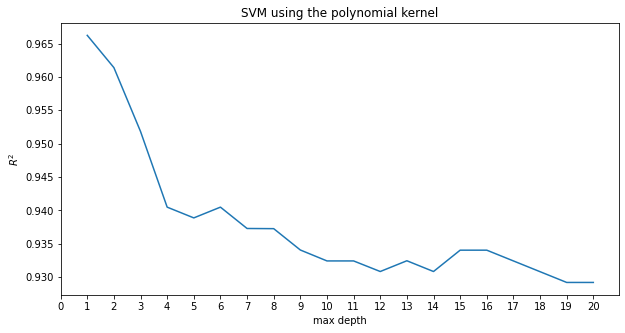

<Figure size 432x288 with 0 Axes>

In [95]:
r_squared = []
for depth in range(1,21):
    r2 = svm_polynomial_kernel(X_train, y_train_1d, 10, depth, random_state=12)
    r_squared.append([depth, r2])

r_squared = np.array(r_squared)

idx = list(range(0, 21))
plt.figure(figsize=(10, 5))
plt.plot(r_squared[:,0], r_squared[:,1])
plt.xticks(range(len(idx)),idx)
plt.xlabel('max depth')
plt.ylabel('$R^2$')
plt.title('SVM using the polynomial kernel')
plt.show()
plt.clf()

In [97]:
maximum = np.max(r_squared[:,1])
index_of_maximum = np.where(r_squared[:,1] == maximum)
print(index_of_maximum[0][0] + 1)
svm_polynomial_kernel(X_train, y_train_1d, 10, index_of_maximum[0][0] + 1, random_state=12)

1


0.9662314388120838

In [98]:
def svm_rbf_kernel(X_rbf, y_rbf, n_folds, C, random_state=None):
    kf = KFold(n_splits=n_folds)
    model = SVC(kernel='rbf', C=C)
    avg_score = 0
    for train_idx, test_idx in kf.split(X_rbf):
        X_train_rbf, X_test_rbf = X_rbf[train_idx], X_rbf[test_idx]
        y_train_rbf, y_test_rbf = y_rbf[train_idx], y_rbf[test_idx]
        
        model.fit(X_train_rbf, y_train_rbf)
        
        r_squared = model.score(X_test_rbf, y_test_rbf)
        
        avg_score += r_squared
    avg_score /= n_folds
    
    return avg_score

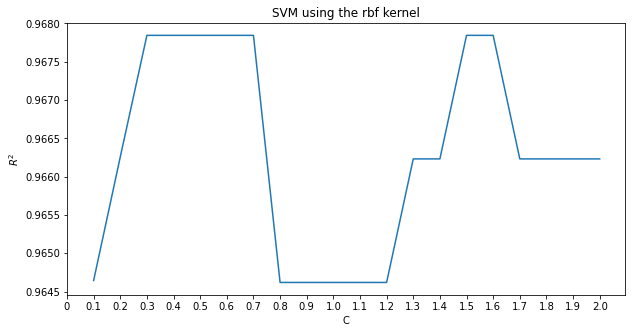

<Figure size 432x288 with 0 Axes>

In [99]:
r_squared = []
C_values = np.arange(0.1,2.1,0.1)
for C in np.arange(0.1,2.1,0.1):
    r2 = svm_rbf_kernel(X_train, y_train_1d, 10, C, random_state=12)
    r_squared.append([C, r2])
    
r_squared = np.array(r_squared)

idx = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
plt.figure(figsize=(10, 5))
plt.plot(r_squared[:,0], r_squared[:,1])
plt.xticks(idx,idx)
plt.xlabel('C')
plt.ylabel('$R^2$')
plt.title('SVM using the rbf kernel')
plt.show()
plt.clf()

In [103]:
maximum = np.max(r_squared[:,1])
index_of_maximum = np.where(r_squared[:,1] == maximum)
print(index_of_maximum[0][0] + 1)
# svm_polynomial_kernel(X_train, y_train_1d, 10, index_of_maximum[0][0] + 1, random_state=12)

svm_rbf_kernel(X_train, y_train_1d, 10, 0.3, random_state=12)

3


0.9678443420378905

In [104]:
def nn_sigmoid(X_sigmoid, y_sigmoid, n_folds, node, random_state=None):
    kf = KFold(n_splits=n_folds)
    model = keras.Sequential(name="sigmoid_model")
    model.add(layers.Dense(node, activation="sigmoid"))
    model.add(layers.Dense(node, activation="sigmoid"))
    model.add(layers.Dense(node, activation="sigmoid"))
    model.add(layers.Dense(2, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    avg_score = 0
    for train_idx, test_idx in kf.split(X_sigmoid):
        X_train_fold, X_test_fold = X_sigmoid[train_idx], X_sigmoid[test_idx]
        y_train_fold, y_test_fold = y_sigmoid[train_idx], y_sigmoid[test_idx]
        
        model.fit(X_train_fold, y_train_fold, epochs = 25)

        val_loss, val_acc = model.evaluate(X_test_fold, y_test_fold, verbose=2)
        avg_score += val_acc
        
    avg_score /= n_folds
    
    return avg_score

Epoch 1/25
18/18 [==============================] - 0s 798us/step - loss: 0.7204 - accuracy: 0.3400
Epoch 2/25
18/18 [==============================] - 0s 938us/step - loss: 0.7091 - accuracy: 0.3567
Epoch 3/25
18/18 [==============================] - 0s 953us/step - loss: 0.7023 - accuracy: 0.3400
Epoch 4/25
18/18 [==============================] - 0s 921us/step - loss: 0.6944 - accuracy: 0.3727
Epoch 5/25
18/18 [==============================] - 0s 861us/step - loss: 0.6882 - accuracy: 0.6721
Epoch 6/25
18/18 [==============================] - 0s 876us/step - loss: 0.6829 - accuracy: 0.6537
Epoch 7/25
18/18 [==============================] - 0s 886us/step - loss: 0.6769 - accuracy: 0.6685
Epoch 8/25
18/18 [==============================] - 0s 985us/step - loss: 0.6764 - accuracy: 0.6379
Epoch 9/25
18/18 [==============================] - 0s 915us/step - loss: 0.6737 - accuracy: 0.6351
Epoch 10/25
18/18 [==============================] - 0s 949us/step - loss: 0.6726 - accuracy: 0.6267

18/18 [==============================] - 0s 810us/step - loss: 0.6256 - accuracy: 0.6655
Epoch 7/25
18/18 [==============================] - 0s 927us/step - loss: 0.6243 - accuracy: 0.6655
Epoch 8/25
18/18 [==============================] - 0s 849us/step - loss: 0.6231 - accuracy: 0.6655
Epoch 9/25
18/18 [==============================] - 0s 804us/step - loss: 0.6217 - accuracy: 0.6655
Epoch 10/25
18/18 [==============================] - 0s 761us/step - loss: 0.6202 - accuracy: 0.6655
Epoch 11/25
18/18 [==============================] - 0s 735us/step - loss: 0.6187 - accuracy: 0.6655
Epoch 12/25
18/18 [==============================] - 0s 748us/step - loss: 0.6169 - accuracy: 0.6655
Epoch 13/25
18/18 [==============================] - 0s 727us/step - loss: 0.6151 - accuracy: 0.6655
Epoch 14/25
18/18 [==============================] - 0s 784us/step - loss: 0.6132 - accuracy: 0.6655
Epoch 15/25
18/18 [==============================] - 0s 766us/step - loss: 0.6111 - accuracy: 0.6655
Epoch

18/18 [==============================] - 0s 718us/step - loss: 0.3263 - accuracy: 0.9535
Epoch 12/25
18/18 [==============================] - 0s 913us/step - loss: 0.3229 - accuracy: 0.9535
Epoch 13/25
18/18 [==============================] - 0s 822us/step - loss: 0.3195 - accuracy: 0.9517
Epoch 14/25
18/18 [==============================] - 0s 757us/step - loss: 0.3160 - accuracy: 0.9553
Epoch 15/25
18/18 [==============================] - 0s 750us/step - loss: 0.3122 - accuracy: 0.9535
Epoch 16/25
18/18 [==============================] - 0s 730us/step - loss: 0.3090 - accuracy: 0.9535
Epoch 17/25
18/18 [==============================] - 0s 747us/step - loss: 0.3054 - accuracy: 0.9535
Epoch 18/25
18/18 [==============================] - 0s 764us/step - loss: 0.3021 - accuracy: 0.9535
Epoch 19/25
18/18 [==============================] - 0s 748us/step - loss: 0.2988 - accuracy: 0.9535
Epoch 20/25
18/18 [==============================] - 0s 728us/step - loss: 0.2954 - accuracy: 0.9535
Ep

18/18 [==============================] - 0s 753us/step - loss: 0.1706 - accuracy: 0.9642
Epoch 17/25
18/18 [==============================] - 0s 813us/step - loss: 0.1699 - accuracy: 0.9642
Epoch 18/25
18/18 [==============================] - 0s 744us/step - loss: 0.1689 - accuracy: 0.9642
Epoch 19/25
18/18 [==============================] - 0s 824us/step - loss: 0.1681 - accuracy: 0.9642
Epoch 20/25
18/18 [==============================] - 0s 783us/step - loss: 0.1673 - accuracy: 0.9642
Epoch 21/25
18/18 [==============================] - 0s 804us/step - loss: 0.1663 - accuracy: 0.9642
Epoch 22/25
18/18 [==============================] - 0s 783us/step - loss: 0.1654 - accuracy: 0.9642
Epoch 23/25
18/18 [==============================] - 0s 744us/step - loss: 0.1648 - accuracy: 0.9642
Epoch 24/25
18/18 [==============================] - 0s 760us/step - loss: 0.1641 - accuracy: 0.9642
Epoch 25/25
18/18 [==============================] - 0s 728us/step - loss: 0.1629 - accuracy: 0.9642
2/

18/18 [==============================] - 0s 1ms/step - loss: 0.6469 - accuracy: 0.6512
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6469 - accuracy: 0.6512
Epoch 23/25
18/18 [==============================] - 0s 2ms/step - loss: 0.6468 - accuracy: 0.6512
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6469 - accuracy: 0.6512
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6469 - accuracy: 0.6512
2/2 - 0s - loss: 0.6308 - accuracy: 0.6774
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6380 - accuracy: 0.6655
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6379 - accuracy: 0.6655
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6379 - accuracy: 0.6655
Epoch 4/25
18/18 [==============================] - 0s 2ms/step - loss: 0.6378 - accuracy: 0.6655
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6377 - a

18/18 [==============================] - 0s 948us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 2/25
18/18 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 3/25
18/18 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 6/25
18/18 [==============================] - 0s 2ms/step - loss: 0.6435 - accuracy: 0.6565
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6435 - accuracy: 0.6565
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 11/25
18/18 [=========

18/18 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 8/25
18/18 [==============================] - 0s 864us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 9/25
18/18 [==============================] - 0s 894us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 10/25
18/18 [==============================] - 0s 976us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 11/25
18/18 [==============================] - 0s 943us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 12/25
18/18 [==============================] - 0s 935us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 13/25
18/18 [==============================] - 0s 822us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 15/25
18/18 [==============================] - 0s 892us/step - loss: 0.6436 - accuracy: 0.6565
Epoch 16/25
18/18 [==============================] - 0s 781us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 17

18/18 [==============================] - 0s 928us/step - loss: 0.6471 - accuracy: 0.6512
Epoch 13/25
18/18 [==============================] - 0s 957us/step - loss: 0.6471 - accuracy: 0.6512
Epoch 14/25
18/18 [==============================] - 0s 959us/step - loss: 0.6471 - accuracy: 0.6512
Epoch 15/25
18/18 [==============================] - 0s 944us/step - loss: 0.6471 - accuracy: 0.6512
Epoch 16/25
18/18 [==============================] - 0s 919us/step - loss: 0.6471 - accuracy: 0.6512
Epoch 17/25
18/18 [==============================] - 0s 944us/step - loss: 0.6471 - accuracy: 0.6512
Epoch 18/25
18/18 [==============================] - 0s 930us/step - loss: 0.6471 - accuracy: 0.6512
Epoch 19/25
18/18 [==============================] - 0s 953us/step - loss: 0.6471 - accuracy: 0.6512
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6472 - accuracy: 0.6512
Epoch 21/25
18/18 [==============================] - 0s 980us/step - loss: 0.6470 - accuracy: 0.6512
Epoc

18/18 [==============================] - 0s 985us/step - loss: 0.6468 - accuracy: 0.6512
Epoch 18/25
18/18 [==============================] - 0s 944us/step - loss: 0.6469 - accuracy: 0.6512
Epoch 19/25
18/18 [==============================] - 0s 951us/step - loss: 0.6469 - accuracy: 0.6512
Epoch 20/25
18/18 [==============================] - 0s 928us/step - loss: 0.6470 - accuracy: 0.6512
Epoch 21/25
18/18 [==============================] - 0s 913us/step - loss: 0.6469 - accuracy: 0.6512
Epoch 22/25
18/18 [==============================] - 0s 946us/step - loss: 0.6468 - accuracy: 0.6512
Epoch 23/25
18/18 [==============================] - 0s 957us/step - loss: 0.6469 - accuracy: 0.6512
Epoch 24/25
18/18 [==============================] - 0s 943us/step - loss: 0.6469 - accuracy: 0.6512
Epoch 25/25
18/18 [==============================] - 0s 953us/step - loss: 0.6469 - accuracy: 0.6512
2/2 - 0s - loss: 0.6304 - accuracy: 0.6774
Epoch 1/25
18/18 [==============================] - 0s 846us

18/18 [==============================] - 0s 774us/step - loss: 0.5193 - accuracy: 0.6583
Epoch 23/25
18/18 [==============================] - 0s 757us/step - loss: 0.5078 - accuracy: 0.6583
Epoch 24/25
18/18 [==============================] - 0s 802us/step - loss: 0.4959 - accuracy: 0.6583
Epoch 25/25
18/18 [==============================] - 0s 780us/step - loss: 0.4835 - accuracy: 0.6583
2/2 - 0s - loss: 0.5026 - accuracy: 0.6774
Epoch 1/25
18/18 [==============================] - 0s 693us/step - loss: 0.4728 - accuracy: 0.8569
Epoch 2/25
18/18 [==============================] - 0s 746us/step - loss: 0.4602 - accuracy: 0.9231
Epoch 3/25
18/18 [==============================] - 0s 838us/step - loss: 0.4471 - accuracy: 0.9284
Epoch 4/25
18/18 [==============================] - 0s 901us/step - loss: 0.4344 - accuracy: 0.9392
Epoch 5/25
18/18 [==============================] - 0s 800us/step - loss: 0.4218 - accuracy: 0.9374
Epoch 6/25
18/18 [==============================] - 0s 814us/step

18/18 [==============================] - 0s 707us/step - loss: 0.4124 - accuracy: 0.9499
Epoch 2/25
18/18 [==============================] - 0s 739us/step - loss: 0.3982 - accuracy: 0.9499
Epoch 3/25
18/18 [==============================] - 0s 793us/step - loss: 0.3835 - accuracy: 0.9499
Epoch 4/25
18/18 [==============================] - 0s 828us/step - loss: 0.3693 - accuracy: 0.9517
Epoch 5/25
18/18 [==============================] - 0s 784us/step - loss: 0.3557 - accuracy: 0.9517
Epoch 6/25
18/18 [==============================] - 0s 799us/step - loss: 0.3421 - accuracy: 0.9553
Epoch 7/25
18/18 [==============================] - 0s 820us/step - loss: 0.3295 - accuracy: 0.9571
Epoch 8/25
18/18 [==============================] - 0s 772us/step - loss: 0.3170 - accuracy: 0.9553
Epoch 9/25
18/18 [==============================] - 0s 776us/step - loss: 0.3051 - accuracy: 0.9589
Epoch 10/25
18/18 [==============================] - 0s 732us/step - loss: 0.2942 - accuracy: 0.9553
Epoch 11/2

18/18 [==============================] - 0s 918us/step - loss: 0.1094 - accuracy: 0.9678
Epoch 7/25
18/18 [==============================] - 0s 928us/step - loss: 0.1092 - accuracy: 0.9660
Epoch 8/25
18/18 [==============================] - 0s 956us/step - loss: 0.1089 - accuracy: 0.9660
Epoch 9/25
18/18 [==============================] - 0s 914us/step - loss: 0.1083 - accuracy: 0.9678
Epoch 10/25
18/18 [==============================] - 0s 938us/step - loss: 0.1079 - accuracy: 0.9714
Epoch 11/25
18/18 [==============================] - 0s 891us/step - loss: 0.1078 - accuracy: 0.9660
Epoch 12/25
18/18 [==============================] - 0s 910us/step - loss: 0.1068 - accuracy: 0.9732
Epoch 13/25
18/18 [==============================] - 0s 938us/step - loss: 0.1064 - accuracy: 0.9714
Epoch 14/25
18/18 [==============================] - 0s 2ms/step - loss: 0.1064 - accuracy: 0.9696
Epoch 15/25
18/18 [==============================] - 0s 926us/step - loss: 0.1057 - accuracy: 0.9714
Epoch 1

18/18 [==============================] - 0s 926us/step - loss: 0.0751 - accuracy: 0.9785
Epoch 12/25
18/18 [==============================] - 0s 921us/step - loss: 0.0746 - accuracy: 0.9767
Epoch 13/25
18/18 [==============================] - 0s 917us/step - loss: 0.0739 - accuracy: 0.9785
Epoch 14/25
18/18 [==============================] - 0s 997us/step - loss: 0.0738 - accuracy: 0.9785
Epoch 15/25
18/18 [==============================] - 0s 907us/step - loss: 0.0741 - accuracy: 0.9767
Epoch 16/25
18/18 [==============================] - 0s 946us/step - loss: 0.0742 - accuracy: 0.9803
Epoch 17/25
18/18 [==============================] - 0s 961us/step - loss: 0.0727 - accuracy: 0.9803
Epoch 18/25
18/18 [==============================] - 0s 937us/step - loss: 0.0732 - accuracy: 0.9803
Epoch 19/25
18/18 [==============================] - 0s 992us/step - loss: 0.0728 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 965us/step - loss: 0.0721 - accuracy: 0.9785
Ep

18/18 [==============================] - 0s 972us/step - loss: 0.3346 - accuracy: 0.9338
Epoch 17/25
18/18 [==============================] - 0s 996us/step - loss: 0.3222 - accuracy: 0.9374
Epoch 18/25
18/18 [==============================] - 0s 948us/step - loss: 0.3109 - accuracy: 0.9356
Epoch 19/25
18/18 [==============================] - 0s 926us/step - loss: 0.3002 - accuracy: 0.9356
Epoch 20/25
18/18 [==============================] - 0s 959us/step - loss: 0.2905 - accuracy: 0.9392
Epoch 21/25
18/18 [==============================] - 0s 916us/step - loss: 0.2814 - accuracy: 0.9410
Epoch 22/25
18/18 [==============================] - 0s 917us/step - loss: 0.2728 - accuracy: 0.9428
Epoch 23/25
18/18 [==============================] - 0s 912us/step - loss: 0.2657 - accuracy: 0.9428
Epoch 24/25
18/18 [==============================] - 0s 927us/step - loss: 0.2576 - accuracy: 0.9428
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2510 - accuracy: 0.9428
2/2 

18/18 [==============================] - 0s 935us/step - loss: 0.1071 - accuracy: 0.9660
Epoch 22/25
18/18 [==============================] - 0s 933us/step - loss: 0.1066 - accuracy: 0.9660
Epoch 23/25
18/18 [==============================] - 0s 867us/step - loss: 0.1060 - accuracy: 0.9678
Epoch 24/25
18/18 [==============================] - 0s 921us/step - loss: 0.1061 - accuracy: 0.9696
Epoch 25/25
18/18 [==============================] - 0s 852us/step - loss: 0.1050 - accuracy: 0.9678
2/2 - 0s - loss: 0.1968 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 813us/step - loss: 0.1105 - accuracy: 0.9660
Epoch 2/25
18/18 [==============================] - 0s 867us/step - loss: 0.1101 - accuracy: 0.9660
Epoch 3/25
18/18 [==============================] - 0s 898us/step - loss: 0.1105 - accuracy: 0.9678
Epoch 4/25
18/18 [==============================] - 0s 960us/step - loss: 0.1089 - accuracy: 0.9678
Epoch 5/25
18/18 [==============================] - 0s 936us/ste

Epoch 1/25
18/18 [==============================] - 0s 882us/step - loss: 0.0786 - accuracy: 0.9750
Epoch 2/25
18/18 [==============================] - 0s 927us/step - loss: 0.0775 - accuracy: 0.9767
Epoch 3/25
18/18 [==============================] - 0s 928us/step - loss: 0.0769 - accuracy: 0.9767
Epoch 4/25
18/18 [==============================] - 0s 985us/step - loss: 0.0768 - accuracy: 0.9767
Epoch 5/25
18/18 [==============================] - 0s 898us/step - loss: 0.0767 - accuracy: 0.9750
Epoch 6/25
18/18 [==============================] - 0s 934us/step - loss: 0.0761 - accuracy: 0.9750
Epoch 7/25
18/18 [==============================] - 0s 946us/step - loss: 0.0749 - accuracy: 0.9767
Epoch 8/25
18/18 [==============================] - 0s 928us/step - loss: 0.0749 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 900us/step - loss: 0.0752 - accuracy: 0.9767
Epoch 10/25
18/18 [==============================] - 0s 968us/step - loss: 0.0742 - accuracy: 0.9785

18/18 [==============================] - 0s 930us/step - loss: 0.4947 - accuracy: 0.6959
Epoch 7/25
18/18 [==============================] - 0s 902us/step - loss: 0.4789 - accuracy: 0.8140
Epoch 8/25
18/18 [==============================] - 0s 929us/step - loss: 0.4631 - accuracy: 0.8855
Epoch 9/25
18/18 [==============================] - 0s 942us/step - loss: 0.4451 - accuracy: 0.9016
Epoch 10/25
18/18 [==============================] - 0s 986us/step - loss: 0.4276 - accuracy: 0.9106
Epoch 11/25
18/18 [==============================] - 0s 964us/step - loss: 0.4095 - accuracy: 0.9177
Epoch 12/25
18/18 [==============================] - 0s 925us/step - loss: 0.3910 - accuracy: 0.9284
Epoch 13/25
18/18 [==============================] - 0s 960us/step - loss: 0.3724 - accuracy: 0.9302
Epoch 14/25
18/18 [==============================] - 0s 893us/step - loss: 0.3543 - accuracy: 0.9392
Epoch 15/25
18/18 [==============================] - 0s 935us/step - loss: 0.3362 - accuracy: 0.9410
Epoch

18/18 [==============================] - 0s 890us/step - loss: 0.0886 - accuracy: 0.9767
Epoch 12/25
18/18 [==============================] - 0s 973us/step - loss: 0.0879 - accuracy: 0.9785
Epoch 13/25
18/18 [==============================] - 0s 890us/step - loss: 0.0876 - accuracy: 0.9785
Epoch 14/25
18/18 [==============================] - 0s 943us/step - loss: 0.0871 - accuracy: 0.9785
Epoch 15/25
18/18 [==============================] - 0s 953us/step - loss: 0.0864 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 909us/step - loss: 0.0861 - accuracy: 0.9785
Epoch 17/25
18/18 [==============================] - 0s 961us/step - loss: 0.0859 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 949us/step - loss: 0.0853 - accuracy: 0.9785
Epoch 19/25
18/18 [==============================] - 0s 939us/step - loss: 0.0850 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 912us/step - loss: 0.0845 - accuracy: 0.9785
Ep

18/18 [==============================] - 0s 924us/step - loss: 0.0763 - accuracy: 0.9785
Epoch 17/25
18/18 [==============================] - 0s 938us/step - loss: 0.0761 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 947us/step - loss: 0.0762 - accuracy: 0.9785
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0766 - accuracy: 0.9750
Epoch 20/25
18/18 [==============================] - 0s 971us/step - loss: 0.0762 - accuracy: 0.9732
Epoch 21/25
18/18 [==============================] - 0s 998us/step - loss: 0.0757 - accuracy: 0.9785
Epoch 22/25
18/18 [==============================] - 0s 983us/step - loss: 0.0754 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9767
Epoch 24/25
18/18 [==============================] - 0s 965us/step - loss: 0.0754 - accuracy: 0.9785
Epoch 25/25
18/18 [==============================] - 0s 968us/step - loss: 0.0751 - accuracy: 0.9785
2/2 - 

18/18 [==============================] - 0s 909us/step - loss: 0.5472 - accuracy: 0.6424
Epoch 22/25
18/18 [==============================] - 0s 915us/step - loss: 0.5288 - accuracy: 0.6432
Epoch 23/25
18/18 [==============================] - 0s 956us/step - loss: 0.5087 - accuracy: 0.6558
Epoch 24/25
18/18 [==============================] - 0s 928us/step - loss: 0.4730 - accuracy: 0.6791
Epoch 25/25
18/18 [==============================] - 0s 930us/step - loss: 0.4770 - accuracy: 0.7047
2/2 - 0s - loss: 0.4427 - accuracy: 0.8730
Epoch 1/25
18/18 [==============================] - 0s 878us/step - loss: 0.4551 - accuracy: 0.8605
Epoch 2/25
18/18 [==============================] - 0s 933us/step - loss: 0.4364 - accuracy: 0.8801
Epoch 3/25
18/18 [==============================] - 0s 940us/step - loss: 0.4172 - accuracy: 0.9177
Epoch 4/25
18/18 [==============================] - 0s 939us/step - loss: 0.3981 - accuracy: 0.9231
Epoch 5/25
18/18 [==============================] - 0s 907us/ste

Epoch 1/25
18/18 [==============================] - 0s 795us/step - loss: 0.0903 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 876us/step - loss: 0.0898 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 951us/step - loss: 0.0894 - accuracy: 0.9767
Epoch 4/25
18/18 [==============================] - 0s 968us/step - loss: 0.0880 - accuracy: 0.9750
Epoch 5/25
18/18 [==============================] - 0s 925us/step - loss: 0.0881 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 975us/step - loss: 0.0867 - accuracy: 0.9803
Epoch 7/25
18/18 [==============================] - 0s 927us/step - loss: 0.0863 - accuracy: 0.9750
Epoch 8/25
18/18 [==============================] - 0s 956us/step - loss: 0.0851 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 931us/step - loss: 0.0846 - accuracy: 0.9803
Epoch 10/25
18/18 [==============================] - 0s 947us/step - loss: 0.0840 - accuracy: 0.9803

18/18 [==============================] - 0s 948us/step - loss: 0.0765 - accuracy: 0.9750
Epoch 7/25
18/18 [==============================] - 0s 874us/step - loss: 0.0759 - accuracy: 0.9767
Epoch 8/25
18/18 [==============================] - 0s 931us/step - loss: 0.0760 - accuracy: 0.9750
Epoch 9/25
18/18 [==============================] - 0s 920us/step - loss: 0.0756 - accuracy: 0.9767
Epoch 10/25
18/18 [==============================] - 0s 919us/step - loss: 0.0768 - accuracy: 0.9767
Epoch 11/25
18/18 [==============================] - 0s 961us/step - loss: 0.0761 - accuracy: 0.9750
Epoch 12/25
18/18 [==============================] - 0s 963us/step - loss: 0.0753 - accuracy: 0.9750
Epoch 13/25
18/18 [==============================] - 0s 868us/step - loss: 0.0750 - accuracy: 0.9767
Epoch 14/25
18/18 [==============================] - 0s 930us/step - loss: 0.0758 - accuracy: 0.9750
Epoch 15/25
18/18 [==============================] - 0s 929us/step - loss: 0.0757 - accuracy: 0.9750
Epoch

18/18 [==============================] - 0s 961us/step - loss: 0.6349 - accuracy: 0.6517
Epoch 12/25
18/18 [==============================] - 0s 957us/step - loss: 0.6390 - accuracy: 0.6399
Epoch 13/25
18/18 [==============================] - 0s 993us/step - loss: 0.6474 - accuracy: 0.6189
Epoch 14/25
18/18 [==============================] - 0s 989us/step - loss: 0.6231 - accuracy: 0.6549
Epoch 15/25
18/18 [==============================] - 0s 952us/step - loss: 0.6254 - accuracy: 0.6411
Epoch 16/25
18/18 [==============================] - 0s 888us/step - loss: 0.6121 - accuracy: 0.6559
Epoch 17/25
18/18 [==============================] - 0s 952us/step - loss: 0.6143 - accuracy: 0.6340
Epoch 18/25
18/18 [==============================] - 0s 954us/step - loss: 0.5995 - accuracy: 0.6461
Epoch 19/25
18/18 [==============================] - 0s 930us/step - loss: 0.5753 - accuracy: 0.6652
Epoch 20/25
18/18 [==============================] - 0s 942us/step - loss: 0.5676 - accuracy: 0.6549
Ep

18/18 [==============================] - 0s 957us/step - loss: 0.1095 - accuracy: 0.9678
Epoch 17/25
18/18 [==============================] - 0s 988us/step - loss: 0.1090 - accuracy: 0.9678
Epoch 18/25
18/18 [==============================] - 0s 993us/step - loss: 0.1097 - accuracy: 0.9714
Epoch 19/25
18/18 [==============================] - 0s 937us/step - loss: 0.1075 - accuracy: 0.9696
Epoch 20/25
18/18 [==============================] - 0s 976us/step - loss: 0.1071 - accuracy: 0.9696
Epoch 21/25
18/18 [==============================] - 0s 930us/step - loss: 0.1065 - accuracy: 0.9714
Epoch 22/25
18/18 [==============================] - 0s 936us/step - loss: 0.1057 - accuracy: 0.9732
Epoch 23/25
18/18 [==============================] - 0s 919us/step - loss: 0.1049 - accuracy: 0.9714
Epoch 24/25
18/18 [==============================] - 0s 930us/step - loss: 0.1048 - accuracy: 0.9732
Epoch 25/25
18/18 [==============================] - 0s 915us/step - loss: 0.1038 - accuracy: 0.9732
2/

18/18 [==============================] - 0s 974us/step - loss: 0.0791 - accuracy: 0.9750
Epoch 22/25
18/18 [==============================] - 0s 946us/step - loss: 0.0796 - accuracy: 0.9750
Epoch 23/25
18/18 [==============================] - 0s 974us/step - loss: 0.0786 - accuracy: 0.9785
Epoch 24/25
18/18 [==============================] - 0s 936us/step - loss: 0.0789 - accuracy: 0.9767
Epoch 25/25
18/18 [==============================] - 0s 970us/step - loss: 0.0782 - accuracy: 0.9767
2/2 - 0s - loss: 0.0370 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 808us/step - loss: 0.0804 - accuracy: 0.9750
Epoch 2/25
18/18 [==============================] - 0s 835us/step - loss: 0.0803 - accuracy: 0.9767
Epoch 3/25
18/18 [==============================] - 0s 901us/step - loss: 0.0800 - accuracy: 0.9803
Epoch 4/25
18/18 [==============================] - 0s 947us/step - loss: 0.0794 - accuracy: 0.9803
Epoch 5/25
18/18 [==============================] - 0s 949us/ste

Epoch 1/25
18/18 [==============================] - 0s 893us/step - loss: 0.7682 - accuracy: 0.3461
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.7049 - accuracy: 0.3622
Epoch 3/25
18/18 [==============================] - 0s 985us/step - loss: 0.6737 - accuracy: 0.6409
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6528 - accuracy: 0.6678
Epoch 5/25
18/18 [==============================] - 0s 985us/step - loss: 0.6536 - accuracy: 0.6512
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6512 - accuracy: 0.6492
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6490 - accuracy: 0.6496
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6507 - accuracy: 0.6438
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6494 - accuracy: 0.6421
Epoch 10/25
18/18 [==============================] - 0s 992us/step - loss: 0.6388 - accuracy: 0.6561
Epoch 11/25

Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1346 - accuracy: 0.9624
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1331 - accuracy: 0.9642
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1326 - accuracy: 0.9624
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1312 - accuracy: 0.9642
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1311 - accuracy: 0.9624
Epoch 12/25
18/18 [==============================] - 0s 974us/step - loss: 0.1300 - accuracy: 0.9642
Epoch 13/25
18/18 [==============================] - 0s 988us/step - loss: 0.1287 - accuracy: 0.9642
Epoch 14/25
18/18 [==============================] - 0s 992us/step - loss: 0.1273 - accuracy: 0.9660
Epoch 15/25
18/18 [==============================] - 0s 988us/step - loss: 0.1268 - accuracy: 0.9660
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1265 - accuracy: 0.9642
Epoch

Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0946 - accuracy: 0.9732
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9732
Epoch 15/25
18/18 [==============================] - 0s 980us/step - loss: 0.0933 - accuracy: 0.9732
Epoch 16/25
18/18 [==============================] - 0s 990us/step - loss: 0.0933 - accuracy: 0.9732
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0934 - accuracy: 0.9732
Epoch 18/25
18/18 [==============================] - 0s 977us/step - loss: 0.0934 - accuracy: 0.9714
Epoch 19/25
18/18 [==============================] - 0s 976us/step - loss: 0.0922 - accuracy: 0.9732
Epoch 20/25
18/18 [==============================] - 0s 996us/step - loss: 0.0914 - accuracy: 0.9732
Epoch 21/25
18/18 [==============================] - 0s 983us/step - loss: 0.0912 - accuracy: 0.9732
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0908 - accuracy: 0.973

18/18 [==============================] - 0s 991us/step - loss: 0.0791 - accuracy: 0.9785
Epoch 19/25
18/18 [==============================] - 0s 983us/step - loss: 0.0787 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0782 - accuracy: 0.9785
Epoch 21/25
18/18 [==============================] - 0s 984us/step - loss: 0.0784 - accuracy: 0.9785
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0796 - accuracy: 0.9767
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0771 - accuracy: 0.9750
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0783 - accuracy: 0.9767
Epoch 25/25
18/18 [==============================] - 0s 984us/step - loss: 0.0780 - accuracy: 0.9785
2/2 - 0s - loss: 0.0423 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 853us/step - loss: 0.7089 - accuracy: 0.3876
Epoch 2/25
18/18 [==============================] - 0s 922us/step - l

18/18 [==============================] - 0s 965us/step - loss: 0.0774 - accuracy: 0.9767
Epoch 24/25
18/18 [==============================] - 0s 977us/step - loss: 0.0756 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0745 - accuracy: 0.9803
2/2 - 0s - loss: 0.2277 - accuracy: 0.9194
Epoch 1/25
18/18 [==============================] - 0s 969us/step - loss: 0.0883 - accuracy: 0.9732
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.9750
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0858 - accuracy: 0.9767
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0853 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0846 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0841 - accuracy: 0.9767
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0829

18/18 [==============================] - 0s 1ms/step - loss: 0.0739 - accuracy: 0.9785
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0739 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0733 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 993us/step - loss: 0.0741 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 983us/step - loss: 0.0729 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0737 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 977us/step - loss: 0.0731 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 985us/step - loss: 0.0725 - accuracy: 0.9803
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0728 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 985us/step - loss: 0.0722 - accuracy: 0.9803
Epoch 13/25
18/18 

18/18 [==============================] - 0s 999us/step - loss: 0.0682 - accuracy: 0.9803
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9803
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0673 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9803
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0692 - accuracy: 0.9767
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.9821
Epoch 15/25
18/18 [==============================] - 0s 965us/step - loss: 0.0677 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 984us/step - loss: 0.0682 - accuracy: 0.9803
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9803
Epoch 18/25
18/18 [==============================] - 0s 964us/step - loss: 0.0671 - accuracy: 0.9803
Epoch 19/25
18

18/18 [==============================] - 0s 992us/step - loss: 0.0907 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0897 - accuracy: 0.9767
Epoch 17/25
18/18 [==============================] - 0s 960us/step - loss: 0.0892 - accuracy: 0.9767
Epoch 18/25
18/18 [==============================] - 0s 975us/step - loss: 0.0878 - accuracy: 0.9767
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0862 - accuracy: 0.9767
Epoch 20/25
18/18 [==============================] - 0s 962us/step - loss: 0.0847 - accuracy: 0.9785
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0849 - accuracy: 0.9767
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0827 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0817 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 972us/step - loss: 0.0810 - accuracy: 0.9803
Epoch 25/25


18/18 [==============================] - 0s 988us/step - loss: 0.0734 - accuracy: 0.9785
Epoch 22/25
18/18 [==============================] - 0s 986us/step - loss: 0.0745 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0722 - accuracy: 0.9821
Epoch 24/25
18/18 [==============================] - 0s 983us/step - loss: 0.0735 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 960us/step - loss: 0.0721 - accuracy: 0.9803
2/2 - 0s - loss: 0.0489 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 914us/step - loss: 0.0752 - accuracy: 0.9767
Epoch 2/25
18/18 [==============================] - 0s 960us/step - loss: 0.0748 - accuracy: 0.9750
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0737 - accuracy: 0.9767
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0732 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 992us/step - lo

18/18 [==============================] - 0s 899us/step - loss: 0.0694 - accuracy: 0.9767
Epoch 2/25
18/18 [==============================] - 0s 932us/step - loss: 0.0684 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0678 - accuracy: 0.9767
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0688 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 980us/step - loss: 0.0670 - accuracy: 0.9767
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0688 - accuracy: 0.9785
Epoch 8/25
18/18 [==============================] - 0s 983us/step - loss: 0.0672 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0676 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 987us/step - loss: 0.0670 - accuracy: 0.9767
Epoch 11/25
18/18 [=

18/18 [==============================] - 0s 990us/step - loss: 0.1114 - accuracy: 0.9714
Epoch 8/25
18/18 [==============================] - 0s 945us/step - loss: 0.1090 - accuracy: 0.9714
Epoch 9/25
18/18 [==============================] - 0s 2ms/step - loss: 0.1081 - accuracy: 0.9714
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1074 - accuracy: 0.9714
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1044 - accuracy: 0.9696
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1041 - accuracy: 0.9714
Epoch 13/25
18/18 [==============================] - 0s 993us/step - loss: 0.1020 - accuracy: 0.9696
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1008 - accuracy: 0.9696
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0996 - accuracy: 0.9696
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0986 - accuracy: 0.9714
Epoch 17/25
18/18 

18/18 [==============================] - 0s 1ms/step - loss: 0.0795 - accuracy: 0.9750
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0793 - accuracy: 0.9767
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0794 - accuracy: 0.9767
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0788 - accuracy: 0.9767
Epoch 16/25
18/18 [==============================] - 0s 970us/step - loss: 0.0787 - accuracy: 0.9767
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0783 - accuracy: 0.9767
Epoch 18/25
18/18 [==============================] - 0s 987us/step - loss: 0.0795 - accuracy: 0.9767
Epoch 19/25
18/18 [==============================] - 0s 934us/step - loss: 0.0789 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 979us/step - loss: 0.0786 - accuracy: 0.9767
Epoch 21/25
18/18 [==============================] - 0s 977us/step - loss: 0.0783 - accuracy: 0.9767
Epoch 22/25


18/18 [==============================] - 0s 1ms/step - loss: 0.0564 - accuracy: 0.9839
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0560 - accuracy: 0.9857
Epoch 19/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0569 - accuracy: 0.9821
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0562 - accuracy: 0.9839
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0562 - accuracy: 0.9857
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0557 - accuracy: 0.9857
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0557 - accuracy: 0.9857
Epoch 24/25
18/18 [==============================] - 0s 934us/step - loss: 0.0555 - accuracy: 0.9857
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0554 - accuracy: 0.9857
2/2 - 0s - loss: 0.1710 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 863us/step - loss: 0.

18/18 [==============================] - 0s 1ms/step - loss: 0.1350 - accuracy: 0.9624
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1326 - accuracy: 0.9624
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1314 - accuracy: 0.9624
2/2 - 0s - loss: 0.1013 - accuracy: 0.9677
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1126 - accuracy: 0.9714
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1106 - accuracy: 0.9714
Epoch 3/25
18/18 [==============================] - 0s 990us/step - loss: 0.1084 - accuracy: 0.9714
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1072 - accuracy: 0.9732
Epoch 5/25
18/18 [==============================] - 0s 988us/step - loss: 0.1046 - accuracy: 0.9714
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1033 - accuracy: 0.9714
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1023 -

18/18 [==============================] - 0s 1ms/step - loss: 0.0831 - accuracy: 0.9785
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0822 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0825 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0835 - accuracy: 0.9767
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0818 - accuracy: 0.9785
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0815 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0804 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 989us/step - loss: 0.0822 - accuracy: 0.9750
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0803 - accuracy: 0.9785
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0810 - accuracy: 0.9785
Epoch 13/25
18/18 [=======

18/18 [==============================] - 0s 1ms/step - loss: 0.0546 - accuracy: 0.9839
Epoch 10/25
18/18 [==============================] - 0s 984us/step - loss: 0.0545 - accuracy: 0.9857
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0539 - accuracy: 0.9857
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0554 - accuracy: 0.9821
Epoch 13/25
18/18 [==============================] - 0s 976us/step - loss: 0.0535 - accuracy: 0.9857
Epoch 14/25
18/18 [==============================] - 0s 991us/step - loss: 0.0533 - accuracy: 0.9857
Epoch 15/25
18/18 [==============================] - 0s 986us/step - loss: 0.0538 - accuracy: 0.9803
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0537 - accuracy: 0.9857
Epoch 17/25
18/18 [==============================] - 0s 968us/step - loss: 0.0523 - accuracy: 0.9857
Epoch 18/25
18/18 [==============================] - 0s 989us/step - loss: 0.0531 - accuracy: 0.9839
Epoch 19/2

18/18 [==============================] - 0s 1ms/step - loss: 0.1256 - accuracy: 0.9624
Epoch 16/25
18/18 [==============================] - 0s 999us/step - loss: 0.1241 - accuracy: 0.9624
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1224 - accuracy: 0.9624
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1200 - accuracy: 0.9624
Epoch 19/25
18/18 [==============================] - 0s 972us/step - loss: 0.1188 - accuracy: 0.9642
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1176 - accuracy: 0.9678
Epoch 21/25
18/18 [==============================] - 0s 963us/step - loss: 0.1152 - accuracy: 0.9660
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1143 - accuracy: 0.9696
Epoch 23/25
18/18 [==============================] - 0s 962us/step - loss: 0.1129 - accuracy: 0.9678
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1111 - accuracy: 0.9696
Epoch 25/25
18

18/18 [==============================] - 0s 1ms/step - loss: 0.0644 - accuracy: 0.9821
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9821
Epoch 23/25
18/18 [==============================] - 0s 973us/step - loss: 0.0639 - accuracy: 0.9839
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0637 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 984us/step - loss: 0.0644 - accuracy: 0.9821
2/2 - 0s - loss: 0.1143 - accuracy: 0.9677
Epoch 1/25
18/18 [==============================] - 0s 989us/step - loss: 0.0715 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 931us/step - loss: 0.0730 - accuracy: 0.9803
Epoch 3/25
18/18 [==============================] - 0s 967us/step - loss: 0.0736 - accuracy: 0.9750
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0690 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 

18/18 [==============================] - 0s 986us/step - loss: 0.0497 - accuracy: 0.9875
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0495 - accuracy: 0.9857
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0491 - accuracy: 0.9857
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0490 - accuracy: 0.9839
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0514 - accuracy: 0.9857
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0490 - accuracy: 0.9857
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0476 - accuracy: 0.9857
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0485 - accuracy: 0.9857
Epoch 10/25
18/18 [==============================] - 0s 980us/step - loss: 0.0480 - accuracy: 0.9857
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0474 - accuracy: 0.9857
Epoch 12/25
18/18 [======

18/18 [==============================] - 0s 1ms/step - loss: 0.1264 - accuracy: 0.9642
Epoch 9/25
18/18 [==============================] - 0s 964us/step - loss: 0.1238 - accuracy: 0.9660
Epoch 10/25
18/18 [==============================] - 0s 999us/step - loss: 0.1217 - accuracy: 0.9660
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1179 - accuracy: 0.9660
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1164 - accuracy: 0.9660
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1135 - accuracy: 0.9660
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1119 - accuracy: 0.9660
Epoch 15/25
18/18 [==============================] - 0s 992us/step - loss: 0.1102 - accuracy: 0.9660
Epoch 16/25
18/18 [==============================] - 0s 985us/step - loss: 0.1076 - accuracy: 0.9678
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1065 - accuracy: 0.9696
Epoch 18/25
18/

18/18 [==============================] - 0s 989us/step - loss: 0.0640 - accuracy: 0.9839
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0643 - accuracy: 0.9821
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.9821
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9821
Epoch 18/25
18/18 [==============================] - 0s 1000us/step - loss: 0.0633 - accuracy: 0.9821
Epoch 19/25
18/18 [==============================] - 0s 982us/step - loss: 0.0638 - accuracy: 0.9821
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9839
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.9821
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0631 - accuracy: 0.9821
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0627 - accuracy: 0.9821
Epoch 24/25
18/

18/18 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.9821
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0605 - accuracy: 0.9821
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0607 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 978us/step - loss: 0.0605 - accuracy: 0.9857
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0602 - accuracy: 0.9821
Epoch 25/25
18/18 [==============================] - 0s 998us/step - loss: 0.0622 - accuracy: 0.9821
2/2 - 0s - loss: 0.0054 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 911us/step - loss: 0.0455 - accuracy: 0.9875
Epoch 2/25
18/18 [==============================] - 0s 974us/step - loss: 0.0458 - accuracy: 0.9839
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0448 - accuracy: 0.9893
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0

Epoch 1/25
18/18 [==============================] - 0s 954us/step - loss: 0.1865 - accuracy: 0.9571
Epoch 2/25
18/18 [==============================] - 0s 971us/step - loss: 0.1776 - accuracy: 0.9553
Epoch 3/25
18/18 [==============================] - 0s 937us/step - loss: 0.1695 - accuracy: 0.9571
Epoch 4/25
18/18 [==============================] - 0s 933us/step - loss: 0.1625 - accuracy: 0.9571
Epoch 5/25
18/18 [==============================] - 0s 963us/step - loss: 0.1564 - accuracy: 0.9589
Epoch 6/25
18/18 [==============================] - 0s 959us/step - loss: 0.1518 - accuracy: 0.9624
Epoch 7/25
18/18 [==============================] - 0s 924us/step - loss: 0.1475 - accuracy: 0.9624
Epoch 8/25
18/18 [==============================] - 0s 952us/step - loss: 0.1442 - accuracy: 0.9606
Epoch 9/25
18/18 [==============================] - 0s 928us/step - loss: 0.1398 - accuracy: 0.9606
Epoch 10/25
18/18 [==============================] - 0s 913us/step - loss: 0.1371 - accuracy: 0.9606

18/18 [==============================] - 0s 956us/step - loss: 0.0695 - accuracy: 0.9767
Epoch 7/25
18/18 [==============================] - 0s 941us/step - loss: 0.0700 - accuracy: 0.9767
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0692 - accuracy: 0.9767
Epoch 9/25
18/18 [==============================] - 0s 950us/step - loss: 0.0714 - accuracy: 0.9767
Epoch 10/25
18/18 [==============================] - 0s 930us/step - loss: 0.0690 - accuracy: 0.9803
Epoch 11/25
18/18 [==============================] - 0s 976us/step - loss: 0.0711 - accuracy: 0.9785
Epoch 12/25
18/18 [==============================] - 0s 980us/step - loss: 0.0685 - accuracy: 0.9767
Epoch 13/25
18/18 [==============================] - 0s 936us/step - loss: 0.0681 - accuracy: 0.9767
Epoch 14/25
18/18 [==============================] - 0s 950us/step - loss: 0.0678 - accuracy: 0.9785
Epoch 15/25
18/18 [==============================] - 0s 940us/step - loss: 0.0677 - accuracy: 0.9767
Epoch 1

18/18 [==============================] - 0s 960us/step - loss: 0.0679 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 965us/step - loss: 0.0680 - accuracy: 0.9803
Epoch 13/25
18/18 [==============================] - 0s 924us/step - loss: 0.0681 - accuracy: 0.9785
Epoch 14/25
18/18 [==============================] - 0s 960us/step - loss: 0.0682 - accuracy: 0.9803
Epoch 15/25
18/18 [==============================] - 0s 932us/step - loss: 0.0685 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 952us/step - loss: 0.0683 - accuracy: 0.9803
Epoch 17/25
18/18 [==============================] - 0s 947us/step - loss: 0.0675 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 949us/step - loss: 0.0686 - accuracy: 0.9785
Epoch 19/25
18/18 [==============================] - 0s 932us/step - loss: 0.0676 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 945us/step - loss: 0.0679 - accuracy: 0.9803
Ep

18/18 [==============================] - 0s 964us/step - loss: 0.2992 - accuracy: 0.9415
Epoch 17/25
18/18 [==============================] - 0s 929us/step - loss: 0.2720 - accuracy: 0.9310
Epoch 18/25
18/18 [==============================] - 0s 995us/step - loss: 0.2395 - accuracy: 0.9524
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2157 - accuracy: 0.9458
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1993 - accuracy: 0.9520
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1544 - accuracy: 0.9731
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1696 - accuracy: 0.9618
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1686 - accuracy: 0.9556
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1701 - accuracy: 0.9545
Epoch 25/25
18/18 [==============================] - 0s 976us/step - loss: 0.1307 - accuracy: 0.9694
2/2 - 0s - los

18/18 [==============================] - 0s 907us/step - loss: 0.0687 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 952us/step - loss: 0.0688 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 971us/step - loss: 0.0680 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 952us/step - loss: 0.0688 - accuracy: 0.9803
2/2 - 0s - loss: 0.0959 - accuracy: 0.9677
Epoch 1/25
18/18 [==============================] - 0s 974us/step - loss: 0.0706 - accuracy: 0.9803
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0722 - accuracy: 0.9803
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9785
Epoch 4/25
18/18 [==============================] - 0s 978us/step - loss: 0.0689 - accuracy: 0.9803
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0692 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss:

18/18 [==============================] - 0s 973us/step - loss: 0.0697 - accuracy: 0.9750
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0674 - accuracy: 0.9785
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0677 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0689 - accuracy: 0.9767
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0666 - accuracy: 0.9767
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0672 - accuracy: 0.9767
Epoch 8/25
18/18 [==============================] - 0s 983us/step - loss: 0.0678 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 984us/step - loss: 0.0678 - accuracy: 0.9767
Epoch 10/25
18/18 [==============================] - 0s 944us/step - loss: 0.0664 - accuracy: 0.9767
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.9821
Epoch 12/25
18/18 [==

18/18 [==============================] - 0s 955us/step - loss: 0.5498 - accuracy: 0.6409
Epoch 9/25
18/18 [==============================] - 0s 938us/step - loss: 0.5002 - accuracy: 0.6642
Epoch 10/25
18/18 [==============================] - 0s 972us/step - loss: 0.4708 - accuracy: 0.8277
Epoch 11/25
18/18 [==============================] - 0s 980us/step - loss: 0.4019 - accuracy: 0.9147
Epoch 12/25
18/18 [==============================] - 0s 978us/step - loss: 0.3491 - accuracy: 0.9388
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2979 - accuracy: 0.9556
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2773 - accuracy: 0.9313
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2388 - accuracy: 0.9321
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2141 - accuracy: 0.9432
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1868 - accuracy: 0.9460
Epoch 18/25
1

18/18 [==============================] - 0s 1ms/step - loss: 0.0763 - accuracy: 0.9803
Epoch 15/25
18/18 [==============================] - 0s 991us/step - loss: 0.0716 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0756 - accuracy: 0.9732
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0718 - accuracy: 0.9803
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0722 - accuracy: 0.9803
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0727 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0740 - accuracy: 0.9785
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0723 - accuracy: 0.9803
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0717 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0715 - accuracy: 0.9803
Epoch 24/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9803
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0689 - accuracy: 0.9803
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0690 - accuracy: 0.9767
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0678 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0676 - accuracy: 0.9803
2/2 - 0s - loss: 0.0452 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 883us/step - loss: 0.0720 - accuracy: 0.9767
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0746 - accuracy: 0.9767
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0754 - accuracy: 0.9732
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0741 

18/18 [==============================] - 0s 929us/step - loss: 0.8177 - accuracy: 0.3694
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.7020 - accuracy: 0.4425
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6526 - accuracy: 0.6519
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6531 - accuracy: 0.6285
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6542 - accuracy: 0.6226
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6376 - accuracy: 0.6399
Epoch 7/25
18/18 [==============================] - 0s 988us/step - loss: 0.6345 - accuracy: 0.6351
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6230 - accuracy: 0.6394
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.5963 - accuracy: 0.6687
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.5843 - accuracy: 0.6633
Epoch 11/25
18/18 [=======

18/18 [==============================] - 0s 1ms/step - loss: 0.0732 - accuracy: 0.9785
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0732 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0724 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0720 - accuracy: 0.9785
Epoch 11/25
18/18 [==============================] - 0s 988us/step - loss: 0.0723 - accuracy: 0.9767
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0720 - accuracy: 0.9785
Epoch 13/25
18/18 [==============================] - 0s 967us/step - loss: 0.0715 - accuracy: 0.9785
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0711 - accuracy: 0.9785
Epoch 15/25
18/18 [==============================] - 0s 996us/step - loss: 0.0717 - accuracy: 0.9767
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0717 - accuracy: 0.9785
Epoch 17/25
18/18 

18/18 [==============================] - 0s 1ms/step - loss: 0.0677 - accuracy: 0.9785
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0678 - accuracy: 0.9767
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0685 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0679 - accuracy: 0.9767
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0675 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0679 - accuracy: 0.9785
Epoch 19/25
18/18 [==============================] - 0s 988us/step - loss: 0.0674 - accuracy: 0.9767
Epoch 20/25
18/18 [==============================] - 0s 978us/step - loss: 0.0671 - accuracy: 0.9785
Epoch 21/25
18/18 [==============================] - 0s 993us/step - loss: 0.0673 - accuracy: 0.9785
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0693 - accuracy: 0.9785
Epoch 23/25
18/1

18/18 [==============================] - 0s 996us/step - loss: 0.0616 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0632 - accuracy: 0.9767
Epoch 21/25
18/18 [==============================] - 0s 989us/step - loss: 0.0617 - accuracy: 0.9803
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0623 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0613 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0654 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 978us/step - loss: 0.0609 - accuracy: 0.9803
2/2 - 0s - loss: 0.0384 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 906us/step - loss: 0.6633 - accuracy: 0.6750
Epoch 2/25
18/18 [==============================] - 0s 948us/step - loss: 0.6410 - accuracy: 0.6495
Epoch 3/25
18/18 [==============================] - 0s 994us/step - lo

18/18 [==============================] - 0s 999us/step - loss: 0.0642 - accuracy: 0.9821
Epoch 25/25
18/18 [==============================] - 0s 991us/step - loss: 0.0639 - accuracy: 0.9821
2/2 - 0s - loss: 0.2435 - accuracy: 0.9355
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0812 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0811 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0807 - accuracy: 0.9785
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0789 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0798 - accuracy: 0.9767
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0777 - accuracy: 0.9767
Epoch 7/25
18/18 [==============================] - 0s 993us/step - loss: 0.0777 - accuracy: 0.9785
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0793 

Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0699 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0695 - accuracy: 0.9767
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0703 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0707 - accuracy: 0.9750
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0698 - accuracy: 0.9803
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0700 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 994us/step - loss: 0.0683 - accuracy: 0.9803
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9767
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9785
Epoch 15/25
1

18/18 [==============================] - 0s 1ms/step - loss: 0.0609 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 994us/step - loss: 0.0606 - accuracy: 0.9821
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0600 - accuracy: 0.9821
Epoch 14/25
18/18 [==============================] - 0s 999us/step - loss: 0.0601 - accuracy: 0.9821
Epoch 15/25
18/18 [==============================] - 0s 991us/step - loss: 0.0592 - accuracy: 0.9821
Epoch 16/25
18/18 [==============================] - 0s 972us/step - loss: 0.0621 - accuracy: 0.9803
Epoch 17/25
18/18 [==============================] - 0s 993us/step - loss: 0.0644 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 991us/step - loss: 0.0668 - accuracy: 0.9803
Epoch 19/25
18/18 [==============================] - 0s 976us/step - loss: 0.0598 - accuracy: 0.9821
Epoch 20/25
18/18 [==============================] - 0s 981us/step - loss: 0.0607 - accuracy: 0.9821
Epoch 

18/18 [==============================] - 0s 1ms/step - loss: 0.0603 - accuracy: 0.9821
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0591 - accuracy: 0.9839
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0604 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0583 - accuracy: 0.9839
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0582 - accuracy: 0.9839
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0604 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0608 - accuracy: 0.9821
Epoch 24/25
18/18 [==============================] - 0s 993us/step - loss: 0.0597 - accuracy: 0.9821
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0590 - accuracy: 0.9839
2/2 - 0s - loss: 0.2424 - accuracy: 0.9355
Epoch 1/25
18/18 [==============================] - 0s 893us/step - loss: 0.

18/18 [==============================] - 0s 1ms/step - loss: 0.0716 - accuracy: 0.9767
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0700 - accuracy: 0.9785
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9785
2/2 - 0s - loss: 0.0374 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 932us/step - loss: 0.0718 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0720 - accuracy: 0.9767
Epoch 3/25
18/18 [==============================] - 0s 994us/step - loss: 0.0699 - accuracy: 0.9803
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0700 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0707 - accuracy: 0.9767
Epoch 6/25
18/18 [==============================] - 0s 961us/step - loss: 0.0695 - accuracy: 0.9803
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0707

Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0717 - accuracy: 0.9767
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0685 - accuracy: 0.9767
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0658 - accuracy: 0.9767
Epoch 7/25
18/18 [==============================] - 0s 984us/step - loss: 0.0647 - accuracy: 0.9767
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0646 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0650 - accuracy: 0.9803
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9767
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0644 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.9785
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9785
Epoch 14/25
18

18/18 [==============================] - 0s 989us/step - loss: 0.0634 - accuracy: 0.9821
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0610 - accuracy: 0.9821
Epoch 12/25
18/18 [==============================] - 0s 996us/step - loss: 0.0611 - accuracy: 0.9821
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0610 - accuracy: 0.9821
Epoch 14/25
18/18 [==============================] - 0s 998us/step - loss: 0.0603 - accuracy: 0.9803
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0589 - accuracy: 0.9821
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0584 - accuracy: 0.9821
Epoch 17/25
18/18 [==============================] - 0s 992us/step - loss: 0.0592 - accuracy: 0.9839
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0594 - accuracy: 0.9803
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0579 - accuracy: 0.9839
Epoch 20/25
18

18/18 [==============================] - 0s 1ms/step - loss: 0.0674 - accuracy: 0.9785
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0660 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.9785
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy: 0.9821
Epoch 21/25
18/18 [==============================] - 0s 998us/step - loss: 0.0637 - accuracy: 0.9785
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.9785
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0641 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0635 - accuracy: 0.9803
2/2 - 0s - loss: 0.0

18/18 [==============================] - 0s 1ms/step - loss: 0.0471 - accuracy: 0.9839
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9875
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0462 - accuracy: 0.9857
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 0.9857
2/2 - 0s - loss: 0.1581 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 915us/step - loss: 0.0609 - accuracy: 0.9821
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0598 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 985us/step - loss: 0.0589 - accuracy: 0.9803
Epoch 4/25
18/18 [==============================] - 0s 997us/step - loss: 0.0594 - accuracy: 0.9803
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0618 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.058

18/18 [==============================] - 0s 977us/step - loss: 0.0711 - accuracy: 0.9767
Epoch 4/25
18/18 [==============================] - 0s 941us/step - loss: 0.0688 - accuracy: 0.9821
Epoch 5/25
18/18 [==============================] - 0s 967us/step - loss: 0.0674 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0658 - accuracy: 0.9803
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0661 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0651 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9821
Epoch 10/25
18/18 [==============================] - 0s 991us/step - loss: 0.0649 - accuracy: 0.9821
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0638 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0631 - accuracy: 0.9821
Epoch 13/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0703 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9767
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0693 - accuracy: 0.9750
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0691 - accuracy: 0.9803
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9767
Epoch 14/25
18/18 [==============================] - 0s 1000us/step - loss: 0.0736 - accuracy: 0.9767
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0696 - accuracy: 0.9767
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.9785
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9803
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0705 - accuracy: 0.9767
Epoch 19/25
18/18 [

18/18 [==============================] - 0s 1ms/step - loss: 0.0508 - accuracy: 0.9857
Epoch 16/25
18/18 [==============================] - 0s 973us/step - loss: 0.0504 - accuracy: 0.9839
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0499 - accuracy: 0.9857
Epoch 18/25
18/18 [==============================] - 0s 980us/step - loss: 0.0508 - accuracy: 0.9839
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0505 - accuracy: 0.9821
Epoch 20/25
18/18 [==============================] - 0s 996us/step - loss: 0.0500 - accuracy: 0.9875
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0531 - accuracy: 0.9785
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0496 - accuracy: 0.9857
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0506 - accuracy: 0.9839
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0500 - accuracy: 0.9839
Epoch 25/25
18/1

18/18 [==============================] - 0s 981us/step - loss: 0.0866 - accuracy: 0.9767
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0865 - accuracy: 0.9750
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0853 - accuracy: 0.9767
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0857 - accuracy: 0.9785
Epoch 25/25
18/18 [==============================] - 0s 999us/step - loss: 0.0843 - accuracy: 0.9767
2/2 - 0s - loss: 0.0458 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 880us/step - loss: 0.0653 - accuracy: 0.9839
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0649 - accuracy: 0.9839
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0627 - accuracy: 0.9821
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0619 - accuracy: 0.9821
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.06

18/18 [==============================] - 0s 897us/step - loss: 0.0733 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0722 - accuracy: 0.9767
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0714 - accuracy: 0.9767
Epoch 4/25
18/18 [==============================] - 0s 989us/step - loss: 0.0734 - accuracy: 0.9767
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0700 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 984us/step - loss: 0.0701 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 988us/step - loss: 0.0715 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0713 - accuracy: 0.9767
Epoch 9/25
18/18 [==============================] - 0s 964us/step - loss: 0.0701 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9785
Epoch 11/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0481 - accuracy: 0.9839
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0479 - accuracy: 0.9857
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0477 - accuracy: 0.9875
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0488 - accuracy: 0.9839
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0477 - accuracy: 0.9857
Epoch 12/25
18/18 [==============================] - 0s 997us/step - loss: 0.0467 - accuracy: 0.9875
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0476 - accuracy: 0.9839
Epoch 14/25
18/18 [==============================] - 0s 981us/step - loss: 0.0466 - accuracy: 0.9875
Epoch 15/25
18/18 [==============================] - 0s 996us/step - loss: 0.0468 - accuracy: 0.9875
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0476 - accuracy: 0.9893
Epoch 17/25
18/18 

18/18 [==============================] - 0s 952us/step - loss: 0.0974 - accuracy: 0.9732
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0966 - accuracy: 0.9732
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0950 - accuracy: 0.9732
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0939 - accuracy: 0.9732
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0927 - accuracy: 0.9732
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0915 - accuracy: 0.9750
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0903 - accuracy: 0.9767
Epoch 20/25
18/18 [==============================] - 0s 999us/step - loss: 0.0901 - accuracy: 0.9732
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0892 - accuracy: 0.9767
Epoch 22/25
18/18 [==============================] - 0s 997us/step - loss: 0.0896 - accuracy: 0.9750
Epoch 23/25
18/1

18/18 [==============================] - 0s 1ms/step - loss: 0.0633 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 939us/step - loss: 0.0633 - accuracy: 0.9785
Epoch 21/25
18/18 [==============================] - 0s 970us/step - loss: 0.0628 - accuracy: 0.9803
Epoch 22/25
18/18 [==============================] - 0s 967us/step - loss: 0.0636 - accuracy: 0.9821
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0632 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0632 - accuracy: 0.9785
Epoch 25/25
18/18 [==============================] - 0s 999us/step - loss: 0.0638 - accuracy: 0.9821
2/2 - 0s - loss: 0.0919 - accuracy: 0.9677
Epoch 1/25
18/18 [==============================] - 0s 887us/step - loss: 0.0697 - accuracy: 0.9767
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0692 - accuracy: 0.9767
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss

18/18 [==============================] - 0s 1ms/step - loss: 0.0625 - accuracy: 0.9803
2/2 - 0s - loss: 0.0075 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 914us/step - loss: 0.0499 - accuracy: 0.9839
Epoch 2/25
18/18 [==============================] - 0s 993us/step - loss: 0.0479 - accuracy: 0.9839
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0477 - accuracy: 0.9857
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0475 - accuracy: 0.9875
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0469 - accuracy: 0.9857
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0480 - accuracy: 0.9839
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0462 - accuracy: 0.9857
Epoch 8/25
18/18 [==============================] - 0s 997us/step - loss: 0.0461 - accuracy: 0.9857
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0455 -

18/18 [==============================] - 0s 1ms/step - loss: 0.1205 - accuracy: 0.9678
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1185 - accuracy: 0.9678
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1170 - accuracy: 0.9660
Epoch 9/25
18/18 [==============================] - 0s 969us/step - loss: 0.1142 - accuracy: 0.9660
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1142 - accuracy: 0.9660
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1113 - accuracy: 0.9696
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1107 - accuracy: 0.9696
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1085 - accuracy: 0.9714
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1059 - accuracy: 0.9678
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1062 - accuracy: 0.9714
Epoch 16/25
18/18 [====

18/18 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9803
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0690 - accuracy: 0.9803
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9785
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0678 - accuracy: 0.9821
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0690 - accuracy: 0.9803
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0677 - accuracy: 0.9803
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0672 - accuracy: 0.9821
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0671 - accuracy: 0.9821
Epoch 22/25
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.0708 - accuracy: 0.9767
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0706 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0707 - accuracy: 0.9785
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0706 - accuracy: 0.9803
Epoch 22/25
18/18 [==============================] - 0s 1000us/step - loss: 0.0721 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0698 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0712 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0720 - accuracy: 0.9785
2/2 - 0s - loss: 0.0077 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 944us/step - loss: 0.0557 - accuracy: 0.9839
Epoch 2/25
18/18 [==============================] - 0s 967us/step - loss: 

18/18 [==============================] - 0s 1ms/step - loss: 0.1064 - accuracy: 0.9691
Epoch 25/25
18/18 [==============================] - 0s 985us/step - loss: 0.1110 - accuracy: 0.9727
2/2 - 0s - loss: 0.1299 - accuracy: 0.9524
Epoch 1/25
18/18 [==============================] - 0s 916us/step - loss: 0.1110 - accuracy: 0.9678
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1114 - accuracy: 0.9660
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1064 - accuracy: 0.9696
Epoch 4/25
18/18 [==============================] - 0s 1000us/step - loss: 0.1030 - accuracy: 0.9678
Epoch 5/25
18/18 [==============================] - 0s 995us/step - loss: 0.0994 - accuracy: 0.9732
Epoch 6/25
18/18 [==============================] - 0s 993us/step - loss: 0.0989 - accuracy: 0.9696
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0954 - accuracy: 0.9732
Epoch 8/25
18/18 [==============================] - 0s 1000us/step - loss:

Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0634 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 997us/step - loss: 0.0644 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0640 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.9821
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0627 - accuracy: 0.9785
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0619 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0617 - accuracy: 0.9857
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0623 - accuracy: 0.9839
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0628 - accuracy: 0.9821
Epoch 15/25
1

18/18 [==============================] - 0s 2ms/step - loss: 0.0608 - accuracy: 0.9821
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0606 - accuracy: 0.9803
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0601 - accuracy: 0.9839
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0609 - accuracy: 0.9803
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0623 - accuracy: 0.9803
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0608 - accuracy: 0.9821
Epoch 17/25
18/18 [==============================] - 0s 989us/step - loss: 0.0609 - accuracy: 0.9803
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0603 - accuracy: 0.9821
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0619 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 991us/step - loss: 0.0590 - accuracy: 0.9803
Epoch 21/25
18/18 

18/18 [==============================] - 0s 1ms/step - loss: 0.1290 - accuracy: 0.9662
Epoch 18/25
18/18 [==============================] - 0s 957us/step - loss: 0.1170 - accuracy: 0.9686
Epoch 19/25
18/18 [==============================] - 0s 961us/step - loss: 0.1472 - accuracy: 0.9642
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1406 - accuracy: 0.9598
Epoch 21/25
18/18 [==============================] - 0s 991us/step - loss: 0.1275 - accuracy: 0.9615
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1230 - accuracy: 0.9708
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1173 - accuracy: 0.9670
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1239 - accuracy: 0.9586
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1002 - accuracy: 0.9750
2/2 - 0s - loss: 0.1265 - accuracy: 0.9524
Epoch 1/25
18/18 [==============================] - 0s 924us/step - loss

18/18 [==============================] - 0s 1ms/step - loss: 0.0688 - accuracy: 0.9767
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0687 - accuracy: 0.9785
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9803
2/2 - 0s - loss: 0.0888 - accuracy: 0.9677
Epoch 1/25
18/18 [==============================] - 0s 999us/step - loss: 0.0676 - accuracy: 0.9821
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0669 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0664 - accuracy: 0.9803
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0665 - accuracy: 0.9821
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0654 - accuracy: 0.9857
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0659 - accuracy: 0.9803
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0652 - a

18/18 [==============================] - 0s 1ms/step - loss: 0.0692 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 952us/step - loss: 0.0669 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 926us/step - loss: 0.0676 - accuracy: 0.9803
Epoch 7/25
18/18 [==============================] - 0s 952us/step - loss: 0.0670 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 989us/step - loss: 0.0675 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0664 - accuracy: 0.9803
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0676 - accuracy: 0.9803
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0669 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0663 - accuracy: 0.9803
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9803
Epoch 14/25
18/18 [

18/18 [==============================] - 0s 970us/step - loss: 0.3096 - accuracy: 0.9466
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2505 - accuracy: 0.9491
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2187 - accuracy: 0.9597
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1779 - accuracy: 0.9560
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1612 - accuracy: 0.9572
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1356 - accuracy: 0.9758
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1457 - accuracy: 0.9591
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1380 - accuracy: 0.9675
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1224 - accuracy: 0.9686
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1200 - accuracy: 0.9741
Epoch 20/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9767
Epoch 17/25
18/18 [==============================] - 0s 981us/step - loss: 0.0677 - accuracy: 0.9803
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0690 - accuracy: 0.9767
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0679 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0683 - accuracy: 0.9785
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0665 - accuracy: 0.9785
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0672 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0670 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0669 - accuracy: 0.9767
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0664 - accuracy: 0.9785
2/2 - 0s - loss: 0.0

18/18 [==============================] - 0s 1ms/step - loss: 0.0669 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0666 - accuracy: 0.9767
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 994us/step - loss: 0.0672 - accuracy: 0.9803
2/2 - 0s - loss: 0.0500 - accuracy: 0.9677
Epoch 1/25
18/18 [==============================] - 0s 958us/step - loss: 0.0686 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0710 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0701 - accuracy: 0.9750
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0689 - accuracy: 0.9803
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0684 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0682 

18/18 [==============================] - 0s 1ms/step - loss: 0.6208 - accuracy: 0.6567
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6016 - accuracy: 0.6608
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.5934 - accuracy: 0.6339
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.5594 - accuracy: 0.6389
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.5284 - accuracy: 0.6285
Epoch 8/25
18/18 [==============================] - 0s 981us/step - loss: 0.4503 - accuracy: 0.7926
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.3870 - accuracy: 0.9378
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.3258 - accuracy: 0.9421
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2635 - accuracy: 0.9543
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2320 - accuracy: 0.9503
Epoch 13/25
18/18 [=======

18/18 [==============================] - 0s 1ms/step - loss: 0.0716 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0720 - accuracy: 0.9767
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0759 - accuracy: 0.9767
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0722 - accuracy: 0.9785
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0743 - accuracy: 0.9785
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0780 - accuracy: 0.9750
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0727 - accuracy: 0.9767
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9785
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0703 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0694 - accuracy: 0.9803
Epoch 19/25
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.0662 - accuracy: 0.9803
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9803
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0628 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0627 - accuracy: 0.9803
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0627 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0614 - accuracy: 0.9803
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0631 - accuracy: 0.9803
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0620 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0623 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0631 - accuracy: 0.9803
Epoch 25/25
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.0532 - accuracy: 0.9857
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0545 - accuracy: 0.9839
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0538 - accuracy: 0.9839
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0529 - accuracy: 0.9857
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0582 - accuracy: 0.9767
2/2 - 0s - loss: 0.0409 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 966us/step - loss: 0.9366 - accuracy: 0.3557
Epoch 2/25
18/18 [==============================] - 0s 989us/step - loss: 0.6530 - accuracy: 0.6940
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6310 - accuracy: 0.6337
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6108 - accuracy: 0.6369
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.5902

Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0740 - accuracy: 0.9767
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0739 - accuracy: 0.9750
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0730 - accuracy: 0.9803
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0734 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0727 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0727 - accuracy: 0.9785
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0709 - accuracy: 0.9785
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0699 - accuracy: 0.9785
Epoch 12/25
18/18 

18/18 [==============================] - 0s 1ms/step - loss: 0.0674 - accuracy: 0.9750
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0675 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 942us/step - loss: 0.0679 - accuracy: 0.9750
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0670 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0687 - accuracy: 0.9767
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0679 - accuracy: 0.9785
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0660 - accuracy: 0.9785
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0679 - accuracy: 0.9767
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9803
Epoch 18/25
18/18 [==

18/18 [==============================] - 0s 958us/step - loss: 0.0637 - accuracy: 0.9803
Epoch 15/25
18/18 [==============================] - 0s 970us/step - loss: 0.0650 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0612 - accuracy: 0.9821
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0614 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0615 - accuracy: 0.9803
Epoch 19/25
18/18 [==============================] - 0s 998us/step - loss: 0.0619 - accuracy: 0.9821
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0610 - accuracy: 0.9803
Epoch 21/25
18/18 [==============================] - 0s 999us/step - loss: 0.0622 - accuracy: 0.9803
Epoch 22/25
18/18 [==============================] - 0s 963us/step - loss: 0.0640 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 954us/step - loss: 0.0617 - accuracy: 0.9785
Epoch 24/2

18/18 [==============================] - 0s 1ms/step - loss: 0.0565 - accuracy: 0.9857
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0568 - accuracy: 0.9839
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0562 - accuracy: 0.9839
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0571 - accuracy: 0.9821
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0563 - accuracy: 0.9821
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0576 - accuracy: 0.9821
2/2 - 0s - loss: 0.2457 - accuracy: 0.9194
Epoch 1/25
18/18 [==============================] - 0s 991us/step - loss: 0.0744 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0736 - accuracy: 0.9750
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0716 - accuracy: 0.9750
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0714 

18/18 [==============================] - 0s 934us/step - loss: 0.0666 - accuracy: 0.9750
Epoch 2/25
18/18 [==============================] - 0s 948us/step - loss: 0.0662 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0669 - accuracy: 0.9750
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0649 - accuracy: 0.9767
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0662 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0664 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9767
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0670 - accuracy: 0.9732
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 971us/step - loss: 0.0641 - accuracy: 0.9785
Epoch 11/25
18/18 [=====

18/18 [==============================] - 0s 944us/step - loss: 0.0620 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 943us/step - loss: 0.0602 - accuracy: 0.9767
Epoch 9/25
18/18 [==============================] - 0s 923us/step - loss: 0.0609 - accuracy: 0.9785
Epoch 10/25
18/18 [==============================] - 0s 923us/step - loss: 0.0646 - accuracy: 0.9785
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0600 - accuracy: 0.9821
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0635 - accuracy: 0.9785
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9803
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0574 - accuracy: 0.9803
Epoch 15/25
18/18 [==============================] - 0s 990us/step - loss: 0.0590 - accuracy: 0.9803
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0590 - accuracy: 0.9785
Epoch 17/25
18

18/18 [==============================] - 0s 1ms/step - loss: 0.0583 - accuracy: 0.9839
Epoch 14/25
18/18 [==============================] - 0s 929us/step - loss: 0.0583 - accuracy: 0.9839
Epoch 15/25
18/18 [==============================] - 0s 972us/step - loss: 0.0580 - accuracy: 0.9803
Epoch 16/25
18/18 [==============================] - 0s 931us/step - loss: 0.0572 - accuracy: 0.9839
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0592 - accuracy: 0.9821
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9839
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0561 - accuracy: 0.9839
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0578 - accuracy: 0.9839
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0550 - accuracy: 0.9839
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9839
Epoch 23/25
18/1

18/18 [==============================] - 0s 1ms/step - loss: 0.0678 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0688 - accuracy: 0.9803
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0695 - accuracy: 0.9767
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0707 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 996us/step - loss: 0.0671 - accuracy: 0.9785
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0669 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 978us/step - loss: 0.0669 - accuracy: 0.9785
2/2 - 0s - loss: 0.0436 - accuracy: 0.9677
Epoch 1/25
18/18 [==============================] - 0s 856us/step - loss: 0.0680 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 985us/step - loss: 0.0690 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 

18/18 [==============================] - 0s 981us/step - loss: 0.0468 - accuracy: 0.9875
2/2 - 0s - loss: 0.1770 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 940us/step - loss: 0.0690 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 956us/step - loss: 0.0630 - accuracy: 0.9821
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0629 - accuracy: 0.9803
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0619 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0621 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0621 - accuracy: 0.9839
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.9785
Epoch 8/25
18/18 [==============================] - 0s 992us/step - loss: 0.0626 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0609

18/18 [==============================] - 0s 1ms/step - loss: 0.0595 - accuracy: 0.9821
Epoch 7/25
18/18 [==============================] - 0s 992us/step - loss: 0.0598 - accuracy: 0.9785
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0584 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0583 - accuracy: 0.9839
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0566 - accuracy: 0.9803
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0575 - accuracy: 0.9821
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0562 - accuracy: 0.9839
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0569 - accuracy: 0.9839
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0555 - accuracy: 0.9839
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0552 - accuracy: 0.9821
Epoch 16/25
18/18 [====

18/18 [==============================] - 0s 1ms/step - loss: 0.0695 - accuracy: 0.9785
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0693 - accuracy: 0.9785
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0742 - accuracy: 0.9750
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0709 - accuracy: 0.9732
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0672 - accuracy: 0.9803
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0689 - accuracy: 0.9803
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9767
Epoch 19/25
18/18 [==============================] - 0s 983us/step - loss: 0.0689 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0751 - accuracy: 0.9732
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0701 - accuracy: 0.9732
Epoch 22/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0495 - accuracy: 0.9875
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0492 - accuracy: 0.9857
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0500 - accuracy: 0.9857
Epoch 21/25
18/18 [==============================] - 0s 982us/step - loss: 0.0479 - accuracy: 0.9857
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0481 - accuracy: 0.9857
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0482 - accuracy: 0.9893
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0505 - accuracy: 0.9857
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0490 - accuracy: 0.9821
2/2 - 0s - loss: 0.1714 - accuracy: 0.9355
Epoch 1/25
18/18 [==============================] - 0s 979us/step - loss: 0.0649 - accuracy: 0.9803
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0

18/18 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.9732
Epoch 25/25
18/18 [==============================] - 0s 984us/step - loss: 0.0837 - accuracy: 0.9767
2/2 - 0s - loss: 0.0435 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 906us/step - loss: 0.0651 - accuracy: 0.9857
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0628 - accuracy: 0.9803
Epoch 3/25
18/18 [==============================] - 0s 1000us/step - loss: 0.0642 - accuracy: 0.9803
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0615 - accuracy: 0.9821
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0613 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0598 - accuracy: 0.9821
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0594 - accuracy: 0.9821
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0593

18/18 [==============================] - 0s 1ms/step - loss: 0.0700 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0685 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0680 - accuracy: 0.9767
Epoch 10/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9803
Epoch 11/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0674 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9821
Epoch 13/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.9767
Epoch 14/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9803
Epoch 15/25
18/18 [=======

18/18 [==============================] - 0s 1ms/step - loss: 0.0508 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0466 - accuracy: 0.9857
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0454 - accuracy: 0.9857
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0449 - accuracy: 0.9893
Epoch 15/25
18/18 [==============================] - 0s 976us/step - loss: 0.0451 - accuracy: 0.9875
Epoch 16/25
18/18 [==============================] - 0s 998us/step - loss: 0.0450 - accuracy: 0.9857
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0450 - accuracy: 0.9875
Epoch 18/25
18/18 [==============================] - 0s 974us/step - loss: 0.0463 - accuracy: 0.9875
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0455 - accuracy: 0.9857
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0446 - accuracy: 0.9893
Epoch 21/25
18/1

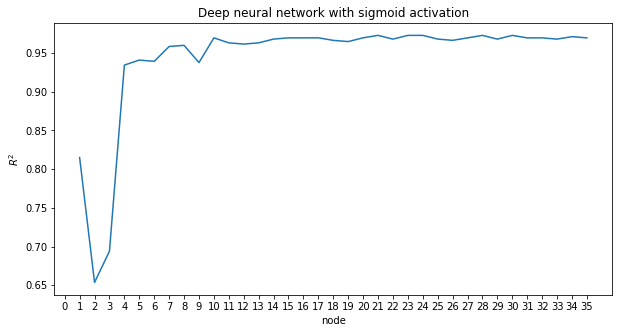

<Figure size 432x288 with 0 Axes>

In [105]:
r_squared = []
for node in range(1,36):
    r2 = nn_sigmoid(X_train, y_train_onehot, 10, node, random_state=12)
    r_squared.append([node, r2])

r_squared = np.array(r_squared)

idx = list(range(0, 36))
plt.figure(figsize=(10, 5))
plt.plot(r_squared[:,0], r_squared[:,1])
plt.xticks(range(len(idx)),idx)
plt.xlabel('node')
plt.ylabel('$R^2$')
plt.title('Deep neural network with sigmoid activation')
plt.show()
plt.clf()

In [118]:
# nn_sigmoid(X_train, y_train_onehot, 10, 30, random_state=12)
maximum = np.max(r_squared[:,1])
index_of_maximum = np.where(r_squared[:,1] == maximum)
print(index_of_maximum)
print(r_squared)
# nn_sigmoid(X_train, y_train_onehot, 10, 27, random_state=12)

(array([20]),)
[[ 1.          0.81495136]
 [ 2.          0.65366104]
 [ 3.          0.69398362]
 [ 4.          0.93430619]
 [ 5.          0.9407578 ]
 [ 6.          0.9391449 ]
 [ 7.          0.95826933]
 [ 8.          0.95980542]
 [ 9.          0.937532  ]
 [10.          0.96943164]
 [11.          0.96300562]
 [12.          0.96144392]
 [13.          0.96300563]
 [14.          0.96784434]
 [15.          0.96945724]
 [16.          0.96945724]
 [17.          0.96948285]
 [18.          0.96623144]
 [19.          0.96464413]
 [20.          0.96948285]
 [21.          0.97268305]
 [22.          0.96781874]
 [23.          0.97265745]
 [24.          0.97265745]
 [25.          0.96786994]
 [26.          0.96623144]
 [27.          0.96943164]
 [28.          0.97265745]
 [29.          0.96781874]
 [30.          0.97265745]
 [31.          0.96943164]
 [32.          0.96943164]
 [33.          0.96781874]
 [34.          0.97101894]
 [35.          0.96943164]]


In [119]:
def nn_relu(X_relu, y_relu, n_folds, node, random_state=None):
    kf = KFold(n_splits=n_folds)
    model = keras.Sequential(name="relu_model")
    model.add(layers.Dense(node, activation="relu"))
    model.add(layers.Dense(node, activation="relu"))
    model.add(layers.Dense(node, activation="relu"))
    model.add(layers.Dense(2, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    avg_score = 0
    for train_idx, test_idx in kf.split(X_relu):
        X_train_relu, X_test_relu = X_relu[train_idx], X_relu[test_idx]
        y_train_relu, y_test_relu = y_relu[train_idx], y_relu[test_idx]
        
        model.fit(X_train_relu, y_train_relu, epochs = 25)

        val_loss, val_acc = model.evaluate(X_test_relu, y_test_relu, verbose=2)
        avg_score += val_acc
        
    avg_score /= n_folds
    
    return avg_score

Epoch 1/25
18/18 [==============================] - 0s 879us/step - loss: 0.6920 - accuracy: 0.6319
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.6734
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6841 - accuracy: 0.6347
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6790 - accuracy: 0.6543
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6773 - accuracy: 0.6375
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6704 - accuracy: 0.6646
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6668 - accuracy: 0.6652
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6672 - accuracy: 0.6490
Epoch 9/25
18/18 [==============================] - 0s 983us/step - loss: 0.6615 - accuracy: 0.6645
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6668 - accuracy: 0.6345
Epoch 11/25
18/

18/18 [==============================] - 0s 961us/step - loss: 0.6377 - accuracy: 0.6655
Epoch 7/25
18/18 [==============================] - 0s 931us/step - loss: 0.6375 - accuracy: 0.6655
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6376 - accuracy: 0.6655
Epoch 9/25
18/18 [==============================] - 0s 851us/step - loss: 0.6375 - accuracy: 0.6655
Epoch 10/25
18/18 [==============================] - 0s 915us/step - loss: 0.6375 - accuracy: 0.6655
Epoch 11/25
18/18 [==============================] - 0s 951us/step - loss: 0.6375 - accuracy: 0.6655
Epoch 12/25
18/18 [==============================] - 0s 955us/step - loss: 0.6374 - accuracy: 0.6655
Epoch 13/25
18/18 [==============================] - 0s 948us/step - loss: 0.6374 - accuracy: 0.6655
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6375 - accuracy: 0.6655
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6374 - accuracy: 0.6655
Epoch 16/25

18/18 [==============================] - 0s 927us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 13/25
18/18 [==============================] - 0s 920us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 14/25
18/18 [==============================] - 0s 946us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 15/25
18/18 [==============================] - 0s 904us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 16/25
18/18 [==============================] - 0s 909us/step - loss: 0.6435 - accuracy: 0.6565
Epoch 17/25
18/18 [==============================] - 0s 910us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 18/25
18/18 [==============================] - 0s 935us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 19/25
18/18 [==============================] - 0s 934us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 20/25
18/18 [==============================] - 0s 940us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6433 - accuracy: 0.6565
Epoc

18/18 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 19/25
18/18 [==============================] - 0s 971us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 20/25
18/18 [==============================] - 0s 970us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 21/25
18/18 [==============================] - 0s 968us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 22/25
18/18 [==============================] - 0s 2ms/step - loss: 0.6433 - accuracy: 0.6565
Epoch 23/25
18/18 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6434 - accuracy: 0.6565
Epoch 25/25
18/18 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.6565
2/2 - 0s - loss: 0.6613 - accuracy: 0.6290
Epoch 1/25
18/18 [==============================] - 0s 839us/step - loss: 1.6925 - accuracy: 0.6682
Epoch 2/25
18/18 [==============================] - 0s 875us/step - los

18/18 [==============================] - 0s 2ms/step - loss: 0.6468 - accuracy: 0.6512
Epoch 25/25
18/18 [==============================] - 0s 2ms/step - loss: 0.6468 - accuracy: 0.6512
2/2 - 0s - loss: 0.6304 - accuracy: 0.6774
Epoch 1/25
18/18 [==============================] - 0s 791us/step - loss: 0.6378 - accuracy: 0.6655
Epoch 2/25
18/18 [==============================] - 0s 882us/step - loss: 0.6378 - accuracy: 0.6655
Epoch 3/25
18/18 [==============================] - 0s 928us/step - loss: 0.6378 - accuracy: 0.6655
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6376 - accuracy: 0.6655
Epoch 5/25
18/18 [==============================] - 0s 916us/step - loss: 0.6376 - accuracy: 0.6655
Epoch 6/25
18/18 [==============================] - 0s 942us/step - loss: 0.6375 - accuracy: 0.6655
Epoch 7/25
18/18 [==============================] - 0s 961us/step - loss: 0.6375 - accuracy: 0.6655
Epoch 8/25
18/18 [==============================] - 0s 949us/step - loss:

Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6433 - accuracy: 0.6565
Epoch 5/25
18/18 [==============================] - 0s 987us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 6/25
18/18 [==============================] - 0s 956us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6433 - accuracy: 0.6565
Epoch 8/25
18/18 [==============================] - 0s 896us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 9/25
18/18 [==============================] - 0s 953us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 10/25
18/18 [==============================] - 0s 955us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 11/25
18/18 [==============================] - 0s 950us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 12/25
18/18 [==============================] - 0s 956us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6433 - accuracy: 0.6565
Ep

18/18 [==============================] - 0s 949us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 10/25
18/18 [==============================] - 0s 918us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 11/25
18/18 [==============================] - 0s 993us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 12/25
18/18 [==============================] - 0s 933us/step - loss: 0.6434 - accuracy: 0.6565
Epoch 13/25
18/18 [==============================] - 0s 974us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 14/25
18/18 [==============================] - 0s 890us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 15/25
18/18 [==============================] - 0s 920us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 16/25
18/18 [==============================] - 0s 903us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 17/25
18/18 [==============================] - 0s 956us/step - loss: 0.6433 - accuracy: 0.6565
Epoch 18/25
18/18 [==============================] - 0s 942us/step - loss: 0.6433 - accuracy: 0.6565
Ep

18/18 [==============================] - 0s 1ms/step - loss: 0.0882 - accuracy: 0.9732
Epoch 16/25
18/18 [==============================] - 0s 972us/step - loss: 0.0874 - accuracy: 0.9732
Epoch 17/25
18/18 [==============================] - 0s 947us/step - loss: 0.0855 - accuracy: 0.9767
Epoch 18/25
18/18 [==============================] - 0s 954us/step - loss: 0.0858 - accuracy: 0.9732
Epoch 19/25
18/18 [==============================] - 0s 965us/step - loss: 0.0855 - accuracy: 0.9767
Epoch 20/25
18/18 [==============================] - 0s 937us/step - loss: 0.0854 - accuracy: 0.9732
Epoch 21/25
18/18 [==============================] - 0s 920us/step - loss: 0.0832 - accuracy: 0.9750
Epoch 22/25
18/18 [==============================] - 0s 946us/step - loss: 0.0817 - accuracy: 0.9767
Epoch 23/25
18/18 [==============================] - 0s 972us/step - loss: 0.0812 - accuracy: 0.9750
Epoch 24/25
18/18 [==============================] - 0s 968us/step - loss: 0.0807 - accuracy: 0.9750
Epoc

18/18 [==============================] - 0s 954us/step - loss: 0.0769 - accuracy: 0.9750
Epoch 22/25
18/18 [==============================] - 0s 936us/step - loss: 0.0776 - accuracy: 0.9732
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0765 - accuracy: 0.9767
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0769 - accuracy: 0.9732
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0764 - accuracy: 0.9750
2/2 - 0s - loss: 0.0533 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0776 - accuracy: 0.9714
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0770 - accuracy: 0.9714
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0767 - accuracy: 0.9732
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0764 - accuracy: 0.9732
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0759

18/18 [==============================] - 0s 886us/step - loss: 0.0715 - accuracy: 0.9750
Epoch 2/25
18/18 [==============================] - 0s 965us/step - loss: 0.0706 - accuracy: 0.9750
Epoch 3/25
18/18 [==============================] - 0s 992us/step - loss: 0.0703 - accuracy: 0.9750
Epoch 4/25
18/18 [==============================] - 0s 959us/step - loss: 0.0707 - accuracy: 0.9750
Epoch 5/25
18/18 [==============================] - 0s 932us/step - loss: 0.0701 - accuracy: 0.9767
Epoch 6/25
18/18 [==============================] - 0s 938us/step - loss: 0.0700 - accuracy: 0.9767
Epoch 7/25
18/18 [==============================] - 0s 950us/step - loss: 0.0707 - accuracy: 0.9785
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0706 - accuracy: 0.9767
Epoch 9/25
18/18 [==============================] - 0s 914us/step - loss: 0.0696 - accuracy: 0.9767
Epoch 10/25
18/18 [==============================] - 0s 917us/step - loss: 0.0698 - accuracy: 0.9750
Epoch 11/25


18/18 [==============================] - 0s 970us/step - loss: 0.1163 - accuracy: 0.9714
Epoch 7/25
18/18 [==============================] - 0s 901us/step - loss: 0.1161 - accuracy: 0.9696
Epoch 8/25
18/18 [==============================] - 0s 940us/step - loss: 0.1130 - accuracy: 0.9714
Epoch 9/25
18/18 [==============================] - 0s 952us/step - loss: 0.1121 - accuracy: 0.9714
Epoch 10/25
18/18 [==============================] - 0s 922us/step - loss: 0.1109 - accuracy: 0.9714
Epoch 11/25
18/18 [==============================] - 0s 931us/step - loss: 0.1090 - accuracy: 0.9732
Epoch 12/25
18/18 [==============================] - 0s 952us/step - loss: 0.1080 - accuracy: 0.9714
Epoch 13/25
18/18 [==============================] - 0s 975us/step - loss: 0.1069 - accuracy: 0.9714
Epoch 14/25
18/18 [==============================] - 0s 878us/step - loss: 0.1069 - accuracy: 0.9714
Epoch 15/25
18/18 [==============================] - 0s 939us/step - loss: 0.1073 - accuracy: 0.9732
Epoch

18/18 [==============================] - 0s 1ms/step - loss: 0.0963 - accuracy: 0.9678
Epoch 12/25
18/18 [==============================] - 0s 986us/step - loss: 0.0961 - accuracy: 0.9678
Epoch 13/25
18/18 [==============================] - 0s 980us/step - loss: 0.0960 - accuracy: 0.9660
Epoch 14/25
18/18 [==============================] - 0s 960us/step - loss: 0.0960 - accuracy: 0.9678
Epoch 15/25
18/18 [==============================] - 0s 975us/step - loss: 0.0956 - accuracy: 0.9696
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0953 - accuracy: 0.9660
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0948 - accuracy: 0.9678
Epoch 18/25
18/18 [==============================] - 0s 963us/step - loss: 0.0944 - accuracy: 0.9660
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0944 - accuracy: 0.9678
Epoch 20/25
18/18 [==============================] - 0s 989us/step - loss: 0.0941 - accuracy: 0.9660
Epoch 21/2

18/18 [==============================] - 0s 978us/step - loss: 0.0591 - accuracy: 0.9839
Epoch 17/25
18/18 [==============================] - 0s 979us/step - loss: 0.0595 - accuracy: 0.9857
Epoch 18/25
18/18 [==============================] - 0s 932us/step - loss: 0.0594 - accuracy: 0.9839
Epoch 19/25
18/18 [==============================] - 0s 957us/step - loss: 0.0589 - accuracy: 0.9839
Epoch 20/25
18/18 [==============================] - 0s 924us/step - loss: 0.0589 - accuracy: 0.9839
Epoch 21/25
18/18 [==============================] - 0s 944us/step - loss: 0.0582 - accuracy: 0.9839
Epoch 22/25
18/18 [==============================] - 0s 907us/step - loss: 0.0582 - accuracy: 0.9839
Epoch 23/25
18/18 [==============================] - 0s 885us/step - loss: 0.0586 - accuracy: 0.9839
Epoch 24/25
18/18 [==============================] - 0s 895us/step - loss: 0.0581 - accuracy: 0.9857
Epoch 25/25
18/18 [==============================] - 0s 938us/step - loss: 0.0590 - accuracy: 0.9839
2/

18/18 [==============================] - 0s 922us/step - loss: 0.2152 - accuracy: 0.9302
Epoch 22/25
18/18 [==============================] - 0s 942us/step - loss: 0.2098 - accuracy: 0.9302
Epoch 23/25
18/18 [==============================] - 0s 961us/step - loss: 0.2043 - accuracy: 0.9302
Epoch 24/25
18/18 [==============================] - 0s 914us/step - loss: 0.2005 - accuracy: 0.9320
Epoch 25/25
18/18 [==============================] - 0s 910us/step - loss: 0.1955 - accuracy: 0.9320
2/2 - 0s - loss: 0.1693 - accuracy: 0.9677
Epoch 1/25
18/18 [==============================] - 0s 829us/step - loss: 0.1726 - accuracy: 0.9445
Epoch 2/25
18/18 [==============================] - 0s 883us/step - loss: 0.1674 - accuracy: 0.9463
Epoch 3/25
18/18 [==============================] - 0s 931us/step - loss: 0.1626 - accuracy: 0.9463
Epoch 4/25
18/18 [==============================] - 0s 927us/step - loss: 0.1582 - accuracy: 0.9499
Epoch 5/25
18/18 [==============================] - 0s 1ms/step 

Epoch 1/25
18/18 [==============================] - 0s 847us/step - loss: 0.0965 - accuracy: 0.9642
Epoch 2/25
18/18 [==============================] - 0s 931us/step - loss: 0.0963 - accuracy: 0.9642
Epoch 3/25
18/18 [==============================] - 0s 943us/step - loss: 0.0962 - accuracy: 0.9642
Epoch 4/25
18/18 [==============================] - 0s 955us/step - loss: 0.0948 - accuracy: 0.9642
Epoch 5/25
18/18 [==============================] - 0s 883us/step - loss: 0.0945 - accuracy: 0.9642
Epoch 6/25
18/18 [==============================] - 0s 891us/step - loss: 0.0941 - accuracy: 0.9642
Epoch 7/25
18/18 [==============================] - 0s 939us/step - loss: 0.0940 - accuracy: 0.9642
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9642
Epoch 9/25
18/18 [==============================] - 0s 932us/step - loss: 0.0941 - accuracy: 0.9642
Epoch 10/25
18/18 [==============================] - 0s 958us/step - loss: 0.0932 - accuracy: 0.9642
E

18/18 [==============================] - 0s 950us/step - loss: 0.0701 - accuracy: 0.9750
Epoch 7/25
18/18 [==============================] - 0s 942us/step - loss: 0.0681 - accuracy: 0.9750
Epoch 8/25
18/18 [==============================] - 0s 926us/step - loss: 0.0677 - accuracy: 0.9732
Epoch 9/25
18/18 [==============================] - 0s 948us/step - loss: 0.0685 - accuracy: 0.9750
Epoch 10/25
18/18 [==============================] - 0s 961us/step - loss: 0.0675 - accuracy: 0.9732
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0675 - accuracy: 0.9750
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0672 - accuracy: 0.9767
Epoch 13/25
18/18 [==============================] - 0s 953us/step - loss: 0.0669 - accuracy: 0.9732
Epoch 14/25
18/18 [==============================] - 0s 914us/step - loss: 0.0667 - accuracy: 0.9732
Epoch 15/25
18/18 [==============================] - 0s 946us/step - loss: 0.0669 - accuracy: 0.9732
Epoch 16/

18/18 [==============================] - 0s 935us/step - loss: 0.1308 - accuracy: 0.9678
Epoch 12/25
18/18 [==============================] - 0s 959us/step - loss: 0.1252 - accuracy: 0.9678
Epoch 13/25
18/18 [==============================] - 0s 974us/step - loss: 0.1228 - accuracy: 0.9678
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1193 - accuracy: 0.9678
Epoch 15/25
18/18 [==============================] - 0s 928us/step - loss: 0.1170 - accuracy: 0.9678
Epoch 16/25
18/18 [==============================] - 0s 965us/step - loss: 0.1149 - accuracy: 0.9678
Epoch 17/25
18/18 [==============================] - 0s 983us/step - loss: 0.1120 - accuracy: 0.9660
Epoch 18/25
18/18 [==============================] - 0s 910us/step - loss: 0.1115 - accuracy: 0.9696
Epoch 19/25
18/18 [==============================] - 0s 964us/step - loss: 0.1103 - accuracy: 0.9624
Epoch 20/25
18/18 [==============================] - 0s 962us/step - loss: 0.1076 - accuracy: 0.9696
Epoc

18/18 [==============================] - 0s 966us/step - loss: 0.0652 - accuracy: 0.9821
Epoch 17/25
18/18 [==============================] - 0s 992us/step - loss: 0.0653 - accuracy: 0.9821
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.9839
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0672 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 957us/step - loss: 0.0647 - accuracy: 0.9839
Epoch 21/25
18/18 [==============================] - 0s 998us/step - loss: 0.0672 - accuracy: 0.9821
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0663 - accuracy: 0.9839
Epoch 23/25
18/18 [==============================] - 0s 951us/step - loss: 0.0669 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 969us/step - loss: 0.0646 - accuracy: 0.9839
Epoch 25/25
18/18 [==============================] - 0s 947us/step - loss: 0.0648 - accuracy: 0.9839
2/2 - 0s

18/18 [==============================] - 0s 955us/step - loss: 0.0628 - accuracy: 0.9803
Epoch 22/25
18/18 [==============================] - 0s 950us/step - loss: 0.0624 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 995us/step - loss: 0.0624 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 922us/step - loss: 0.0664 - accuracy: 0.9767
Epoch 25/25
18/18 [==============================] - 0s 951us/step - loss: 0.0656 - accuracy: 0.9821
2/2 - 0s - loss: 0.0109 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 930us/step - loss: 0.0518 - accuracy: 0.9803
Epoch 2/25
18/18 [==============================] - 0s 943us/step - loss: 0.0507 - accuracy: 0.9857
Epoch 3/25
18/18 [==============================] - 0s 950us/step - loss: 0.0500 - accuracy: 0.9839
Epoch 4/25
18/18 [==============================] - 0s 953us/step - loss: 0.0469 - accuracy: 0.9875
Epoch 5/25
18/18 [==============================] - 0s 985us/ste

18/18 [==============================] - 0s 843us/step - loss: 0.1900 - accuracy: 0.9517
Epoch 2/25
18/18 [==============================] - 0s 873us/step - loss: 0.1866 - accuracy: 0.9535
Epoch 3/25
18/18 [==============================] - 0s 948us/step - loss: 0.1813 - accuracy: 0.9517
Epoch 4/25
18/18 [==============================] - 0s 931us/step - loss: 0.1743 - accuracy: 0.9553
Epoch 5/25
18/18 [==============================] - 0s 898us/step - loss: 0.1705 - accuracy: 0.9571
Epoch 6/25
18/18 [==============================] - 0s 905us/step - loss: 0.1689 - accuracy: 0.9535
Epoch 7/25
18/18 [==============================] - 0s 909us/step - loss: 0.1681 - accuracy: 0.9571
Epoch 8/25
18/18 [==============================] - 0s 920us/step - loss: 0.1645 - accuracy: 0.9535
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1561 - accuracy: 0.9589
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1574 - accuracy: 0.9589
Epoch 11/25
18

18/18 [==============================] - 0s 936us/step - loss: 0.0819 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 953us/step - loss: 0.0839 - accuracy: 0.9732
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0814 - accuracy: 0.9750
Epoch 9/25
18/18 [==============================] - 0s 926us/step - loss: 0.0832 - accuracy: 0.9732
Epoch 10/25
18/18 [==============================] - 0s 972us/step - loss: 0.0825 - accuracy: 0.9767
Epoch 11/25
18/18 [==============================] - 0s 926us/step - loss: 0.0805 - accuracy: 0.9767
Epoch 12/25
18/18 [==============================] - 0s 939us/step - loss: 0.0823 - accuracy: 0.9767
Epoch 13/25
18/18 [==============================] - 0s 938us/step - loss: 0.0808 - accuracy: 0.9750
Epoch 14/25
18/18 [==============================] - 0s 955us/step - loss: 0.0841 - accuracy: 0.9767
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0822 - accuracy: 0.9696
Epoch 16/

18/18 [==============================] - 0s 936us/step - loss: 0.0805 - accuracy: 0.9767
Epoch 12/25
18/18 [==============================] - 0s 979us/step - loss: 0.0805 - accuracy: 0.9767
Epoch 13/25
18/18 [==============================] - 0s 964us/step - loss: 0.0784 - accuracy: 0.9750
Epoch 14/25
18/18 [==============================] - 0s 921us/step - loss: 0.0818 - accuracy: 0.9750
Epoch 15/25
18/18 [==============================] - 0s 993us/step - loss: 0.0784 - accuracy: 0.9767
Epoch 16/25
18/18 [==============================] - 0s 947us/step - loss: 0.0799 - accuracy: 0.9767
Epoch 17/25
18/18 [==============================] - 0s 930us/step - loss: 0.0786 - accuracy: 0.9732
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0774 - accuracy: 0.9767
Epoch 19/25
18/18 [==============================] - 0s 972us/step - loss: 0.0795 - accuracy: 0.9714
Epoch 20/25
18/18 [==============================] - 0s 993us/step - loss: 0.0783 - accuracy: 0.9767
Epoc

18/18 [==============================] - 0s 938us/step - loss: 0.1599 - accuracy: 0.9630
Epoch 17/25
18/18 [==============================] - 0s 931us/step - loss: 0.1925 - accuracy: 0.9566
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1758 - accuracy: 0.9609
Epoch 19/25
18/18 [==============================] - 0s 934us/step - loss: 0.1365 - accuracy: 0.9771
Epoch 20/25
18/18 [==============================] - 0s 897us/step - loss: 0.1371 - accuracy: 0.9699
Epoch 21/25
18/18 [==============================] - 0s 913us/step - loss: 0.1315 - accuracy: 0.9720
Epoch 22/25
18/18 [==============================] - 0s 951us/step - loss: 0.1384 - accuracy: 0.9652
Epoch 23/25
18/18 [==============================] - 0s 909us/step - loss: 0.1399 - accuracy: 0.9607
Epoch 24/25
18/18 [==============================] - 0s 959us/step - loss: 0.1532 - accuracy: 0.9554
Epoch 25/25
18/18 [==============================] - 0s 943us/step - loss: 0.1025 - accuracy: 0.9727
2/2 

18/18 [==============================] - 0s 919us/step - loss: 0.0619 - accuracy: 0.9821
Epoch 22/25
18/18 [==============================] - 0s 925us/step - loss: 0.0614 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 964us/step - loss: 0.0610 - accuracy: 0.9821
Epoch 24/25
18/18 [==============================] - 0s 898us/step - loss: 0.0609 - accuracy: 0.9839
Epoch 25/25
18/18 [==============================] - 0s 926us/step - loss: 0.0628 - accuracy: 0.9767
2/2 - 0s - loss: 0.0815 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0605 - accuracy: 0.9821
Epoch 2/25
18/18 [==============================] - 0s 960us/step - loss: 0.0600 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 953us/step - loss: 0.0596 - accuracy: 0.9821
Epoch 4/25
18/18 [==============================] - 0s 940us/step - loss: 0.0595 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 939us/step 

18/18 [==============================] - 0s 1ms/step - loss: 0.0571 - accuracy: 0.9803
Epoch 2/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0567 - accuracy: 0.9839
Epoch 3/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.9767
Epoch 4/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0565 - accuracy: 0.9785
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0564 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0566 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 918us/step - loss: 0.0561 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 958us/step - loss: 0.0555 - accuracy: 0.9821
Epoch 9/25
18/18 [==============================] - 0s 943us/step - loss: 0.0568 - accuracy: 0.9767
Epoch 10/25
18/18 [==============================] - 0s 954us/step - loss: 0.0551 - accuracy: 0.9821
Epoch 11/25
18/18 [===

18/18 [==============================] - 0s 896us/step - loss: 0.5306 - accuracy: 0.8508
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.4575 - accuracy: 0.8784
Epoch 9/25
18/18 [==============================] - 0s 952us/step - loss: 0.4091 - accuracy: 0.9087
Epoch 10/25
18/18 [==============================] - 0s 958us/step - loss: 0.3619 - accuracy: 0.9129
Epoch 11/25
18/18 [==============================] - 0s 996us/step - loss: 0.3235 - accuracy: 0.9371
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2723 - accuracy: 0.9394
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2552 - accuracy: 0.9430
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2287 - accuracy: 0.9377
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2257 - accuracy: 0.9405
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1844 - accuracy: 0.9537
Epoch 17/25
18/1

18/18 [==============================] - 0s 1ms/step - loss: 0.0704 - accuracy: 0.9785
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0705 - accuracy: 0.9803
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0706 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0696 - accuracy: 0.9785
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0686 - accuracy: 0.9767
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0676 - accuracy: 0.9785
Epoch 19/25
18/18 [==============================] - 0s 981us/step - loss: 0.0684 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 989us/step - loss: 0.0676 - accuracy: 0.9803
Epoch 21/25
18/18 [==============================] - 0s 994us/step - loss: 0.0676 - accuracy: 0.9785
Epoch 22/25
18/18 [==============================] - 0s 982us/step - loss: 0.0669 - accuracy: 0.9785
Epoch 23/25
18

18/18 [==============================] - 0s 986us/step - loss: 0.0571 - accuracy: 0.9767
Epoch 20/25
18/18 [==============================] - 0s 972us/step - loss: 0.0563 - accuracy: 0.9767
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0549 - accuracy: 0.9750
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9767
Epoch 23/25
18/18 [==============================] - 0s 997us/step - loss: 0.0561 - accuracy: 0.9732
Epoch 24/25
18/18 [==============================] - 0s 984us/step - loss: 0.0547 - accuracy: 0.9803
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0550 - accuracy: 0.9839
2/2 - 0s - loss: 0.0368 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 864us/step - loss: 0.0577 - accuracy: 0.9767
Epoch 2/25
18/18 [==============================] - 0s 976us/step - loss: 0.0572 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 977us/step - 

18/18 [==============================] - 0s 994us/step - loss: 0.0438 - accuracy: 0.9857
2/2 - 0s - loss: 0.0399 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.6796 - accuracy: 0.7156
Epoch 2/25
18/18 [==============================] - 0s 980us/step - loss: 0.6075 - accuracy: 0.6789
Epoch 3/25
18/18 [==============================] - 0s 974us/step - loss: 0.5490 - accuracy: 0.8161
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.5206 - accuracy: 0.8817
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.4765 - accuracy: 0.8929
Epoch 6/25
18/18 [==============================] - 0s 999us/step - loss: 0.4298 - accuracy: 0.9205
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.3655 - accuracy: 0.9025
Epoch 8/25
18/18 [==============================] - 0s 978us/step - loss: 0.3033 - accuracy: 0.9224
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.27

18/18 [==============================] - 0s 1ms/step - loss: 0.0599 - accuracy: 0.9785
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0605 - accuracy: 0.9821
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0582 - accuracy: 0.9821
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0562 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 990us/step - loss: 0.0553 - accuracy: 0.9821
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0542 - accuracy: 0.9821
Epoch 11/25
18/18 [==============================] - 0s 995us/step - loss: 0.0544 - accuracy: 0.9821
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0544 - accuracy: 0.9821
Epoch 13/25
18/18 [==============================] - 0s 976us/step - loss: 0.0520 - accuracy: 0.9821
Epoch 14/25
18/18 [==============================] - 0s 990us/step - loss: 0.0514 - accuracy: 0.9839
Epoch 15/25
18/18 

18/18 [==============================] - 0s 968us/step - loss: 0.0297 - accuracy: 0.9875
Epoch 12/25
18/18 [==============================] - 0s 990us/step - loss: 0.0301 - accuracy: 0.9893
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0300 - accuracy: 0.9893
Epoch 14/25
18/18 [==============================] - 0s 981us/step - loss: 0.0291 - accuracy: 0.9875
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0289 - accuracy: 0.9911
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0297 - accuracy: 0.9911
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0298 - accuracy: 0.9875
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0289 - accuracy: 0.9911
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0279 - accuracy: 0.9875
Epoch 20/25
18/18 [==============================] - 0s 992us/step - loss: 0.0278 - accuracy: 0.9911
Epoch 21/25
18

18/18 [==============================] - 0s 1ms/step - loss: 0.0170 - accuracy: 0.9946
Epoch 18/25
18/18 [==============================] - 0s 990us/step - loss: 0.0164 - accuracy: 0.9911
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0163 - accuracy: 0.9946
Epoch 20/25
18/18 [==============================] - 0s 963us/step - loss: 0.0159 - accuracy: 0.9964
Epoch 21/25
18/18 [==============================] - 0s 961us/step - loss: 0.0157 - accuracy: 0.9946
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0144 - accuracy: 0.9964
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0148 - accuracy: 0.9946
Epoch 24/25
18/18 [==============================] - 0s 975us/step - loss: 0.0165 - accuracy: 0.9946
Epoch 25/25
18/18 [==============================] - 0s 983us/step - loss: 0.0162 - accuracy: 0.9964
2/2 - 0s - loss: 0.0232 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 859us/step - 

18/18 [==============================] - 0s 980us/step - loss: 0.0456 - accuracy: 0.9857
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0459 - accuracy: 0.9857
Epoch 25/25
18/18 [==============================] - 0s 990us/step - loss: 0.0447 - accuracy: 0.9857
2/2 - 0s - loss: 0.2147 - accuracy: 0.9194
Epoch 1/25
18/18 [==============================] - 0s 922us/step - loss: 0.0650 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0650 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0615 - accuracy: 0.9803
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0616 - accuracy: 0.9767
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0589 - accuracy: 0.9821
Epoch 6/25
18/18 [==============================] - 0s 987us/step - loss: 0.0580 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.05

18/18 [==============================] - 0s 1ms/step - loss: 0.0415 - accuracy: 0.9839
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0420 - accuracy: 0.9821
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0437 - accuracy: 0.9839
Epoch 6/25
18/18 [==============================] - 0s 978us/step - loss: 0.0432 - accuracy: 0.9803
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0391 - accuracy: 0.9857
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0398 - accuracy: 0.9821
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0388 - accuracy: 0.9839
Epoch 10/25
18/18 [==============================] - 0s 989us/step - loss: 0.0384 - accuracy: 0.9857
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0379 - accuracy: 0.9839
Epoch 12/25
18/18 [==============================] - 0s 976us/step - loss: 0.0402 - accuracy: 0.9821
Epoch 13/25
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.0261 - accuracy: 0.9839
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0326 - accuracy: 0.9857
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0339 - accuracy: 0.9857
Epoch 12/25
18/18 [==============================] - 0s 992us/step - loss: 0.0297 - accuracy: 0.9875
Epoch 13/25
18/18 [==============================] - 0s 954us/step - loss: 0.0260 - accuracy: 0.9875
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.9857
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0258 - accuracy: 0.9839
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0247 - accuracy: 0.9857
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0237 - accuracy: 0.9857
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0254 - accuracy: 0.9857
Epoch 19/25
18/18 

18/18 [==============================] - 0s 963us/step - loss: 0.0624 - accuracy: 0.9821
Epoch 16/25
18/18 [==============================] - 0s 970us/step - loss: 0.0618 - accuracy: 0.9821
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9821
Epoch 18/25
18/18 [==============================] - 0s 967us/step - loss: 0.0630 - accuracy: 0.9803
Epoch 19/25
18/18 [==============================] - 0s 996us/step - loss: 0.0648 - accuracy: 0.9803
Epoch 20/25
18/18 [==============================] - 0s 987us/step - loss: 0.0618 - accuracy: 0.9857
Epoch 21/25
18/18 [==============================] - 0s 980us/step - loss: 0.0598 - accuracy: 0.9821
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0631 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 981us/step - loss: 0.0633 - accuracy: 0.9785
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0580 - accuracy: 0.9839
Epoch 25

18/18 [==============================] - 0s 980us/step - loss: 0.0517 - accuracy: 0.9803
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0506 - accuracy: 0.9839
Epoch 22/25
18/18 [==============================] - 0s 982us/step - loss: 0.0506 - accuracy: 0.9803
Epoch 23/25
18/18 [==============================] - 0s 985us/step - loss: 0.0510 - accuracy: 0.9750
Epoch 24/25
18/18 [==============================] - 0s 979us/step - loss: 0.0505 - accuracy: 0.9839
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0514 - accuracy: 0.9785
2/2 - 0s - loss: 0.0348 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 957us/step - loss: 0.0519 - accuracy: 0.9821
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0507 - accuracy: 0.9785
Epoch 3/25
18/18 [==============================] - 0s 942us/step - loss: 0.0497 - accuracy: 0.9839
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - los

Epoch 1/25
18/18 [==============================] - 0s 894us/step - loss: 0.0344 - accuracy: 0.9857
Epoch 2/25
18/18 [==============================] - 0s 966us/step - loss: 0.0352 - accuracy: 0.9875
Epoch 3/25
18/18 [==============================] - 0s 988us/step - loss: 0.0336 - accuracy: 0.9875
Epoch 4/25
18/18 [==============================] - 0s 956us/step - loss: 0.0325 - accuracy: 0.9911
Epoch 5/25
18/18 [==============================] - 0s 990us/step - loss: 0.0332 - accuracy: 0.9893
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0324 - accuracy: 0.9911
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0339 - accuracy: 0.9875
Epoch 8/25
18/18 [==============================] - 0s 957us/step - loss: 0.0325 - accuracy: 0.9911
Epoch 9/25
18/18 [==============================] - 0s 956us/step - loss: 0.0314 - accuracy: 0.9893
Epoch 10/25
18/18 [==============================] - 0s 976us/step - loss: 0.0331 - accuracy: 0.9911
Epo

18/18 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9803
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0620 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 982us/step - loss: 0.0606 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 996us/step - loss: 0.0604 - accuracy: 0.9803
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0588 - accuracy: 0.9803
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0597 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 977us/step - loss: 0.0586 - accuracy: 0.9821
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0573 - accuracy: 0.9821
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0559 - accuracy: 0.9803
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0558 - accuracy: 0.9821
Epoch 16/25
18/18 [

18/18 [==============================] - 0s 960us/step - loss: 0.0437 - accuracy: 0.9839
Epoch 13/25
18/18 [==============================] - 0s 890us/step - loss: 0.0437 - accuracy: 0.9821
Epoch 14/25
18/18 [==============================] - 0s 986us/step - loss: 0.0443 - accuracy: 0.9821
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0437 - accuracy: 0.9839
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0435 - accuracy: 0.9839
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0427 - accuracy: 0.9821
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0441 - accuracy: 0.9803
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0440 - accuracy: 0.9839
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0452 - accuracy: 0.9785
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0425 - accuracy: 0.9839
Epoch 22/25
18/1

18/18 [==============================] - 0s 1ms/step - loss: 0.0222 - accuracy: 0.9928
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0226 - accuracy: 0.9928
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0221 - accuracy: 0.9928
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0214 - accuracy: 0.9928
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0217 - accuracy: 0.9928
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0214 - accuracy: 0.9946
Epoch 24/25
18/18 [==============================] - 0s 987us/step - loss: 0.0215 - accuracy: 0.9928
Epoch 25/25
18/18 [==============================] - 0s 980us/step - loss: 0.0208 - accuracy: 0.9928
2/2 - 0s - loss: 0.0930 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0302 - accuracy: 0.9857
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0

18/18 [==============================] - 0s 1ms/step - loss: 0.0803 - accuracy: 0.9750
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0793 - accuracy: 0.9750
2/2 - 0s - loss: 0.0463 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 853us/step - loss: 0.0648 - accuracy: 0.9785
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0630 - accuracy: 0.9803
Epoch 3/25
18/18 [==============================] - 0s 996us/step - loss: 0.0601 - accuracy: 0.9821
Epoch 4/25
18/18 [==============================] - 0s 966us/step - loss: 0.0596 - accuracy: 0.9803
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0584 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0552 - accuracy: 0.9821
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0542 - accuracy: 0.9821
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0553 

18/18 [==============================] - 0s 988us/step - loss: 0.0466 - accuracy: 0.9821
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0470 - accuracy: 0.9821
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0469 - accuracy: 0.9821
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0496 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0477 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 981us/step - loss: 0.0482 - accuracy: 0.9821
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0458 - accuracy: 0.9821
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0454 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0467 - accuracy: 0.9803
Epoch 13/25
18/18 [==============================] - 0s 994us/step - loss: 0.0443 - accuracy: 0.9803
Epoch 14/25
18/18 [==

18/18 [==============================] - 0s 1ms/step - loss: 0.0229 - accuracy: 0.9893
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0217 - accuracy: 0.9893
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0210 - accuracy: 0.9893
Epoch 13/25
18/18 [==============================] - 0s 984us/step - loss: 0.0214 - accuracy: 0.9893
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0208 - accuracy: 0.9893
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0207 - accuracy: 0.9911
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0219 - accuracy: 0.9911
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0202 - accuracy: 0.9911
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0197 - accuracy: 0.9893
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0200 - accuracy: 0.9893
Epoch 20/25
18/18 [=

18/18 [==============================] - 0s 1000us/step - loss: 0.0741 - accuracy: 0.9714
Epoch 17/25
18/18 [==============================] - 0s 999us/step - loss: 0.0705 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 970us/step - loss: 0.0674 - accuracy: 0.9732
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0686 - accuracy: 0.9785
Epoch 20/25
18/18 [==============================] - 0s 964us/step - loss: 0.0678 - accuracy: 0.9732
Epoch 21/25
18/18 [==============================] - 0s 987us/step - loss: 0.0643 - accuracy: 0.9750
Epoch 22/25
18/18 [==============================] - 0s 994us/step - loss: 0.0654 - accuracy: 0.9732
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9785
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9767
Epoch 25/25
18/18 [==============================] - 0s 981us/step - loss: 0.0617 - accuracy: 0.9785
2/2 - 0

18/18 [==============================] - 0s 974us/step - loss: 0.0262 - accuracy: 0.9928
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0277 - accuracy: 0.9911
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0287 - accuracy: 0.9875
Epoch 25/25
18/18 [==============================] - 0s 938us/step - loss: 0.0272 - accuracy: 0.9911
2/2 - 0s - loss: 0.1205 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 941us/step - loss: 0.0404 - accuracy: 0.9875
Epoch 2/25
18/18 [==============================] - 0s 960us/step - loss: 0.0399 - accuracy: 0.9875
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0344 - accuracy: 0.9875
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0322 - accuracy: 0.9875
Epoch 5/25
18/18 [==============================] - 0s 997us/step - loss: 0.0313 - accuracy: 0.9893
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0

18/18 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.9982
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 0.9982
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.9982
Epoch 5/25
18/18 [==============================] - 0s 991us/step - loss: 0.0074 - accuracy: 0.9982
Epoch 6/25
18/18 [==============================] - 0s 983us/step - loss: 0.0072 - accuracy: 0.9982
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 0.9982
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0065 - accuracy: 0.9982
Epoch 9/25
18/18 [==============================] - 0s 982us/step - loss: 0.0063 - accuracy: 0.9982
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0066 - accuracy: 0.9982
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.9982
Epoch 12/25
18/18 [====

18/18 [==============================] - 0s 854us/step - loss: 0.1069 - accuracy: 0.9678
Epoch 9/25
18/18 [==============================] - 0s 949us/step - loss: 0.1094 - accuracy: 0.9606
Epoch 10/25
18/18 [==============================] - 0s 986us/step - loss: 0.0998 - accuracy: 0.9535
Epoch 11/25
18/18 [==============================] - 0s 939us/step - loss: 0.0985 - accuracy: 0.9660
Epoch 12/25
18/18 [==============================] - 0s 955us/step - loss: 0.0985 - accuracy: 0.9553
Epoch 13/25
18/18 [==============================] - 0s 918us/step - loss: 0.0911 - accuracy: 0.9624
Epoch 14/25
18/18 [==============================] - 0s 936us/step - loss: 0.0867 - accuracy: 0.9678
Epoch 15/25
18/18 [==============================] - 0s 948us/step - loss: 0.0860 - accuracy: 0.9642
Epoch 16/25
18/18 [==============================] - 0s 972us/step - loss: 0.0821 - accuracy: 0.9678
Epoch 17/25
18/18 [==============================] - 0s 975us/step - loss: 0.0832 - accuracy: 0.9696
Epo

18/18 [==============================] - 0s 982us/step - loss: 0.0259 - accuracy: 0.9928
Epoch 14/25
18/18 [==============================] - 0s 967us/step - loss: 0.0228 - accuracy: 0.9911
Epoch 15/25
18/18 [==============================] - 0s 984us/step - loss: 0.0234 - accuracy: 0.9928
Epoch 16/25
18/18 [==============================] - 0s 972us/step - loss: 0.0272 - accuracy: 0.9911
Epoch 17/25
18/18 [==============================] - 0s 994us/step - loss: 0.0235 - accuracy: 0.9911
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0207 - accuracy: 0.9928
Epoch 19/25
18/18 [==============================] - 0s 958us/step - loss: 0.0208 - accuracy: 0.9928
Epoch 20/25
18/18 [==============================] - 0s 902us/step - loss: 0.0203 - accuracy: 0.9964
Epoch 21/25
18/18 [==============================] - 0s 986us/step - loss: 0.0221 - accuracy: 0.9928
Epoch 22/25
18/18 [==============================] - 0s 961us/step - loss: 0.0214 - accuracy: 0.9928
Epoc

18/18 [==============================] - 0s 933us/step - loss: 0.0084 - accuracy: 0.9964
Epoch 19/25
18/18 [==============================] - 0s 931us/step - loss: 0.0070 - accuracy: 0.9982
Epoch 20/25
18/18 [==============================] - 0s 970us/step - loss: 0.0068 - accuracy: 0.9982
Epoch 21/25
18/18 [==============================] - 0s 969us/step - loss: 0.0075 - accuracy: 0.9982
Epoch 22/25
18/18 [==============================] - 0s 943us/step - loss: 0.0091 - accuracy: 0.9982
Epoch 23/25
18/18 [==============================] - 0s 939us/step - loss: 0.0267 - accuracy: 0.9911
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0240 - accuracy: 0.9928
Epoch 25/25
18/18 [==============================] - 0s 893us/step - loss: 0.0144 - accuracy: 0.9928
2/2 - 0s - loss: 0.0046 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 805us/step - loss: 0.0159 - accuracy: 0.9964
Epoch 2/25
18/18 [==============================] - 0s 841us/st

18/18 [==============================] - 0s 991us/step - loss: 0.1218 - accuracy: 0.9598
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0824 - accuracy: 0.9782
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1011 - accuracy: 0.9697
2/2 - 0s - loss: 0.1714 - accuracy: 0.9048
Epoch 1/25
18/18 [==============================] - 0s 918us/step - loss: 0.1061 - accuracy: 0.9642
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1009 - accuracy: 0.9767
Epoch 3/25
18/18 [==============================] - 0s 993us/step - loss: 0.0974 - accuracy: 0.9642
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.9714
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9696
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0893 - accuracy: 0.9696
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0899

18/18 [==============================] - 0s 1ms/step - loss: 0.0420 - accuracy: 0.9803
Epoch 5/25
18/18 [==============================] - 0s 995us/step - loss: 0.0440 - accuracy: 0.9875
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0378 - accuracy: 0.9875
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0428 - accuracy: 0.9857
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0466 - accuracy: 0.9821
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0423 - accuracy: 0.9803
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0440 - accuracy: 0.9839
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0377 - accuracy: 0.9839
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0424 - accuracy: 0.9839
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0411 - accuracy: 0.9839
Epoch 14/25
18/18 [======

18/18 [==============================] - 0s 1ms/step - loss: 0.0225 - accuracy: 0.9928
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0220 - accuracy: 0.9928
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0220 - accuracy: 0.9928
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0248 - accuracy: 0.9911
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0273 - accuracy: 0.9893
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0211 - accuracy: 0.9928
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0230 - accuracy: 0.9911
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0235 - accuracy: 0.9911
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0201 - accuracy: 0.9928
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0258 - accuracy: 0.9893
Epoch 20/25
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.1342 - accuracy: 0.9672
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1181 - accuracy: 0.9746
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1427 - accuracy: 0.9679
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0980 - accuracy: 0.9819
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1061 - accuracy: 0.9701
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1180 - accuracy: 0.9675
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0982 - accuracy: 0.9785
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1067 - accuracy: 0.9646
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0900 - accuracy: 0.9761
Epoch 25/25
18/18 [==============================] - 0s 1000us/step - loss: 0.1121 - accuracy: 0.9617
2/2 - 0s - loss: 0.

18/18 [==============================] - 0s 978us/step - loss: 0.0260 - accuracy: 0.9911
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0226 - accuracy: 0.9946
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0224 - accuracy: 0.9928
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0224 - accuracy: 0.9928
2/2 - 0s - loss: 0.0455 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0218 - accuracy: 0.9946
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0222 - accuracy: 0.9946
Epoch 3/25
18/18 [==============================] - 0s 987us/step - loss: 0.0199 - accuracy: 0.9946
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0192 - accuracy: 0.9946
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0189 - accuracy: 0.9928
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0186 

18/18 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 0.9982
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0111 - accuracy: 0.9964
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0115 - accuracy: 0.9982
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0136 - accuracy: 0.9928
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0142 - accuracy: 0.9946
Epoch 8/25
18/18 [==============================] - 0s 986us/step - loss: 0.0122 - accuracy: 0.9928
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0130 - accuracy: 0.9928
Epoch 10/25
18/18 [==============================] - 0s 998us/step - loss: 0.0146 - accuracy: 0.9946
Epoch 11/25
18/18 [==============================] - 0s 997us/step - loss: 0.0101 - accuracy: 0.9982
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 0.9982
Epoch 13/25
18/18 [===

18/18 [==============================] - 0s 2ms/step - loss: 0.3080 - accuracy: 0.8953
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2952 - accuracy: 0.8990
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2493 - accuracy: 0.9336
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2454 - accuracy: 0.9174
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2245 - accuracy: 0.9298
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1950 - accuracy: 0.9497
Epoch 15/25
18/18 [==============================] - 0s 940us/step - loss: 0.2171 - accuracy: 0.9359
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1929 - accuracy: 0.9294
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1569 - accuracy: 0.9560
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1809 - accuracy: 0.9521
Epoch 19/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0223 - accuracy: 0.9964
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0238 - accuracy: 0.9946
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0221 - accuracy: 0.9928
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0235 - accuracy: 0.9911
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0211 - accuracy: 0.9946
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0205 - accuracy: 0.9946
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0205 - accuracy: 0.9946
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0201 - accuracy: 0.9928
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0209 - accuracy: 0.9964
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0185 - accuracy: 0.9946
Epoch 25/25
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 1.0000
2/2 - 0s - loss: 5.0201e-04 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 966us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 2/25
18/18 [==============================] - 0s 996us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 4/25
18/18 [==============================] - 0s 990us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 

18/18 [==============================] - 0s 1000us/step - loss: 5.1457e-04 - accuracy: 1.0000
2/2 - 0s - loss: 7.4777e-04 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 945us/step - loss: 0.6648 - accuracy: 0.5164
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.5398 - accuracy: 0.6792
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.4580 - accuracy: 0.8013
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.4023 - accuracy: 0.8729
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.3403 - accuracy: 0.8964
Epoch 6/25
18/18 [==============================] - 0s 997us/step - loss: 0.2762 - accuracy: 0.9266
Epoch 7/25
18/18 [==============================] - 0s 984us/step - loss: 0.2540 - accuracy: 0.9221
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2562 - accuracy: 0.9308
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - los

18/18 [==============================] - 0s 1ms/step - loss: 0.0353 - accuracy: 0.9875
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0336 - accuracy: 0.9875
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0345 - accuracy: 0.9857
Epoch 9/25
18/18 [==============================] - 0s 974us/step - loss: 0.0336 - accuracy: 0.9857
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0319 - accuracy: 0.9839
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0321 - accuracy: 0.9875
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0304 - accuracy: 0.9875
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.9875
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0296 - accuracy: 0.9911
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0338 - accuracy: 0.9839
Epoch 16/25
18/18 [====

18/18 [==============================] - 0s 1ms/step - loss: 0.0173 - accuracy: 0.9946
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0202 - accuracy: 0.9928
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0176 - accuracy: 0.9911
Epoch 15/25
18/18 [==============================] - 0s 967us/step - loss: 0.0164 - accuracy: 0.9946
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0169 - accuracy: 0.9928
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0189 - accuracy: 0.9911
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0188 - accuracy: 0.9946
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0292 - accuracy: 0.9857
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0161 - accuracy: 0.9928
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0149 - accuracy: 0.9946
Epoch 22/25
18/18 [=

18/18 [==============================] - 0s 990us/step - loss: 0.0126 - accuracy: 0.9964
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9982
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 0.9982
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.9982
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.9982
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9982
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 0.9982
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9982
2/2 - 0s - loss: 0.0024 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 983us/step - loss: 0.7577 - accuracy: 0.5889
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.5

18/18 [==============================] - 0s 1ms/step - loss: 0.0338 - accuracy: 0.9893
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0339 - accuracy: 0.9875
2/2 - 0s - loss: 0.2424 - accuracy: 0.9355
Epoch 1/25
18/18 [==============================] - 0s 985us/step - loss: 0.0540 - accuracy: 0.9803
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0625 - accuracy: 0.9767
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0529 - accuracy: 0.9857
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0481 - accuracy: 0.9875
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0481 - accuracy: 0.9893
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0488 - accuracy: 0.9857
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0480 - accuracy: 0.9785
Epoch 8/25
18/18 [==============================] - 0s 977us/step - loss: 0.0440 - 

18/18 [==============================] - 0s 846us/step - loss: 0.0192 - accuracy: 0.9911
Epoch 6/25
18/18 [==============================] - 0s 767us/step - loss: 0.0214 - accuracy: 0.9946
Epoch 7/25
18/18 [==============================] - 0s 756us/step - loss: 0.0212 - accuracy: 0.9946
Epoch 8/25
18/18 [==============================] - 0s 777us/step - loss: 0.0178 - accuracy: 0.9911
Epoch 9/25
18/18 [==============================] - 0s 854us/step - loss: 0.0206 - accuracy: 0.9928
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0191 - accuracy: 0.9928
Epoch 11/25
18/18 [==============================] - 0s 915us/step - loss: 0.0174 - accuracy: 0.9964
Epoch 12/25
18/18 [==============================] - 0s 793us/step - loss: 0.0182 - accuracy: 0.9946
Epoch 13/25
18/18 [==============================] - 0s 865us/step - loss: 0.0234 - accuracy: 0.9911
Epoch 14/25
18/18 [==============================] - 0s 937us/step - loss: 0.0162 - accuracy: 0.9946
Epoch 15

18/18 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 0.9982
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.9982
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9982
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0058 - accuracy: 0.9982
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0087 - accuracy: 0.9982
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.9982
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9982
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 21/25
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.0158 - accuracy: 0.9946
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0170 - accuracy: 0.9946
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0163 - accuracy: 0.9964
Epoch 20/25
18/18 [==============================] - 0s 974us/step - loss: 0.0151 - accuracy: 0.9964
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.9964
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0152 - accuracy: 0.9964
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0152 - accuracy: 0.9964
Epoch 24/25
18/18 [==============================] - 0s 999us/step - loss: 0.0134 - accuracy: 0.9964
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0181 - accuracy: 0.9946
2/2 - 0s - loss: 0.1751 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 919us/step - loss: 

18/18 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9946
Epoch 24/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0115 - accuracy: 0.9982
2/2 - 0s - loss: 0.0089 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0086 - accuracy: 0.9964
Epoch 2/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9982
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0076 - accuracy: 0.9982
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 0.9964
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0214 - accuracy: 0.9964
Epoch 6/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.9911
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0131 - acc

18/18 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 4/25
18/18 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 5/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 6/25
18/18 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 7/25
18/18 [==============================] - 0s 5ms/step - loss: 9.7073e-04 - accuracy: 1.0000
Epoch 8/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 9/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 10/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 11/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 12/25
18/18 [==============================] - 0s 2ms/step - loss: 9.5681e-04 - accuracy: 1.0000
Epoch 13/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9928
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0322 - accuracy: 0.9893
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0326 - accuracy: 0.9893
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.9911
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0304 - accuracy: 0.9911
Epoch 14/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0312 - accuracy: 0.9893
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0318 - accuracy: 0.9928
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0300 - accuracy: 0.9911
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0319 - accuracy: 0.9911
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0354 - accuracy: 0.9893
Epoch 19/25
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9964
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0116 - accuracy: 0.9946
Epoch 17/25
18/18 [==============================] - 0s 5ms/step - loss: 0.0166 - accuracy: 0.9964
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0108 - accuracy: 0.9982
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.9982
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0083 - accuracy: 0.9982
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0081 - accuracy: 0.9982
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0084 - accuracy: 0.9982
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0120 - accuracy: 0.9946
Epoch 25/25
18/18 [===

18/18 [==============================] - 0s 966us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 22/25
18/18 [==============================] - 0s 899us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 23/25
18/18 [==============================] - 0s 909us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 24/25
18/18 [==============================] - 0s 947us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 25/25
18/18 [==============================] - 0s 905us/step - loss: 0.0013 - accuracy: 1.0000
2/2 - 0s - loss: 0.0369 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0100 - accuracy: 0.9946
Epoch 2/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 0.9946
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.9964
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 

18/18 [==============================] - 0s 1ms/step - loss: 0.0578 - accuracy: 0.9875
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0545 - accuracy: 0.9875
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9875
Epoch 4/25
18/18 [==============================] - 0s 969us/step - loss: 0.0536 - accuracy: 0.9857
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0545 - accuracy: 0.9857
Epoch 6/25
18/18 [==============================] - 0s 991us/step - loss: 0.0510 - accuracy: 0.9875
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0496 - accuracy: 0.9857
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0507 - accuracy: 0.9839
Epoch 9/25
18/18 [==============================] - 0s 994us/step - loss: 0.0505 - accuracy: 0.9875
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0475 - accuracy: 0.9857
Epoch 11/25
18/18 [=====

18/18 [==============================] - 0s 1ms/step - loss: 0.0475 - accuracy: 0.9803
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0464 - accuracy: 0.9803
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0471 - accuracy: 0.9803
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0476 - accuracy: 0.9785
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0463 - accuracy: 0.9803
Epoch 12/25
18/18 [==============================] - 0s 994us/step - loss: 0.0470 - accuracy: 0.9785
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0497 - accuracy: 0.9750
Epoch 14/25
18/18 [==============================] - 0s 983us/step - loss: 0.0457 - accuracy: 0.9785
Epoch 15/25
18/18 [==============================] - 0s 981us/step - loss: 0.0435 - accuracy: 0.9803
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0473 - accuracy: 0.9767
Epoch 17/25
18/18 

18/18 [==============================] - 0s 1ms/step - loss: 0.0155 - accuracy: 0.9928
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0149 - accuracy: 0.9946
Epoch 15/25
18/18 [==============================] - 0s 998us/step - loss: 0.0171 - accuracy: 0.9911
Epoch 16/25
18/18 [==============================] - 0s 972us/step - loss: 0.0154 - accuracy: 0.9946
Epoch 17/25
18/18 [==============================] - 0s 960us/step - loss: 0.0137 - accuracy: 0.9928
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0140 - accuracy: 0.9928
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0150 - accuracy: 0.9946
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0143 - accuracy: 0.9964
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0166 - accuracy: 0.9946
Epoch 22/25
18/18 [==============================] - 0s 968us/step - loss: 0.0143 - accuracy: 0.9964
Epoch 23/25
18

18/18 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9821
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0543 - accuracy: 0.9803
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0538 - accuracy: 0.9785
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0609 - accuracy: 0.9767
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.9803
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0530 - accuracy: 0.9839
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0516 - accuracy: 0.9821
2/2 - 0s - loss: 0.0406 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 864us/step - loss: 0.0424 - accuracy: 0.9875
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0410 - accuracy: 0.9839
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0441

18/18 [==============================] - 0s 964us/step - loss: 0.0140 - accuracy: 0.9964
2/2 - 0s - loss: 0.1229 - accuracy: 0.9516
Epoch 1/25
18/18 [==============================] - 0s 866us/step - loss: 0.0256 - accuracy: 0.9875
Epoch 2/25
18/18 [==============================] - 0s 991us/step - loss: 0.0208 - accuracy: 0.9928
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0173 - accuracy: 0.9946
Epoch 4/25
18/18 [==============================] - 0s 985us/step - loss: 0.0191 - accuracy: 0.9928
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0172 - accuracy: 0.9946
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.9964
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0160 - accuracy: 0.9946
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0160 - accuracy: 0.9964
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0165

Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.9982
Epoch 7/25
18/18 [==============================] - 0s 927us/step - loss: 0.0086 - accuracy: 0.9982
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 0.9964
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9982
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 13/25
18/18 [==============================] - 0s 997us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 16/2

18/18 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9821
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0698 - accuracy: 0.9803
Epoch 14/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0679 - accuracy: 0.9803
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0705 - accuracy: 0.9785
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0730 - accuracy: 0.9732
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0681 - accuracy: 0.9785
Epoch 18/25
18/18 [==============================] - 0s 985us/step - loss: 0.0746 - accuracy: 0.9750
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0691 - accuracy: 0.9821
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0661 - accuracy: 0.9785
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0652 - accuracy: 0.9732
Epoch 22/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0242 - accuracy: 0.9893
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0192 - accuracy: 0.9911
Epoch 20/25
18/18 [==============================] - 0s 937us/step - loss: 0.0193 - accuracy: 0.9911
Epoch 21/25
18/18 [==============================] - 0s 940us/step - loss: 0.0210 - accuracy: 0.9893
Epoch 22/25
18/18 [==============================] - 0s 968us/step - loss: 0.0208 - accuracy: 0.9928
Epoch 23/25
18/18 [==============================] - 0s 999us/step - loss: 0.0199 - accuracy: 0.9964
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0208 - accuracy: 0.9911
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0200 - accuracy: 0.9928
2/2 - 0s - loss: 0.0640 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 960us/step - loss: 0.0243 - accuracy: 0.9875
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - los

18/18 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000
2/2 - 0s - loss: 6.4200e-04 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 961us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 2/25
18/18 [==============================] - 0s 929us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.001

18/18 [==============================] - 0s 1ms/step - loss: 0.0646 - accuracy: 0.9803
Epoch 6/25
18/18 [==============================] - 0s 943us/step - loss: 0.0621 - accuracy: 0.9785
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0593 - accuracy: 0.9821
Epoch 8/25
18/18 [==============================] - 0s 991us/step - loss: 0.0609 - accuracy: 0.9785
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0542 - accuracy: 0.9803
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.9857
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0525 - accuracy: 0.9857
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0544 - accuracy: 0.9803
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0497 - accuracy: 0.9821
Epoch 14/25
18/18 [==============================] - 0s 998us/step - loss: 0.0494 - accuracy: 0.9821
Epoch 15/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 13/25
18/18 [==============================] - 0s 996us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.9982
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 20/25
18/18 [==============================] - 0s 972us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 21/25
18/18 

18/18 [==============================] - 0s 1ms/step - loss: 8.0541e-04 - accuracy: 1.0000
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 7.9759e-04 - accuracy: 1.0000
Epoch 19/25
18/18 [==============================] - 0s 2ms/step - loss: 8.3579e-04 - accuracy: 1.0000
Epoch 20/25
18/18 [==============================] - 0s 2ms/step - loss: 8.2162e-04 - accuracy: 1.0000
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 7.9565e-04 - accuracy: 1.0000
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 8.1910e-04 - accuracy: 1.0000
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 7.6505e-04 - accuracy: 1.0000
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 7.5903e-04 - accuracy: 1.0000
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 7.4278e-04 - accuracy: 1.0000
2/2 - 0s - loss: 3.4418e-05 - accuracy: 1.0000
Epoch 1/25
18/18 [====================

18/18 [==============================] - 0s 1ms/step - loss: 0.0985 - accuracy: 0.9774
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0920 - accuracy: 0.9786
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0985 - accuracy: 0.9724
Epoch 24/25
18/18 [==============================] - 0s 996us/step - loss: 0.1072 - accuracy: 0.9622
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1013 - accuracy: 0.9743
2/2 - 0s - loss: 0.1419 - accuracy: 0.9365
Epoch 1/25
18/18 [==============================] - 0s 927us/step - loss: 0.0989 - accuracy: 0.9624
Epoch 2/25
18/18 [==============================] - 0s 957us/step - loss: 0.0919 - accuracy: 0.9714
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0833 - accuracy: 0.9732
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.9678
Epoch 5/25
18/18 [==============================] - 0s 991us/step - loss: 0.

18/18 [==============================] - 0s 1ms/step - loss: 0.0186 - accuracy: 0.9964
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0165 - accuracy: 0.9964
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0207 - accuracy: 0.9911
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0241 - accuracy: 0.9928
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0207 - accuracy: 0.9946
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0172 - accuracy: 0.9911
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0200 - accuracy: 0.9946
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0142 - accuracy: 0.9964
Epoch 10/25
18/18 [==============================] - 0s 993us/step - loss: 0.0139 - accuracy: 0.9946
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0135 - accuracy: 0.9946
Epoch 12/25
18/18 [========

18/18 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 10/25
18/18 [==============================] - 0s 976us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 11/25
18/18 [==============================] - 0s 974us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 18/25
18/18 [

18/18 [==============================] - 0s 934us/step - loss: 0.1636 - accuracy: 0.9570
Epoch 14/25
18/18 [==============================] - 0s 985us/step - loss: 0.1183 - accuracy: 0.9736
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1302 - accuracy: 0.9604
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1025 - accuracy: 0.9740
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1134 - accuracy: 0.9700
Epoch 18/25
18/18 [==============================] - 0s 984us/step - loss: 0.1093 - accuracy: 0.9663
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1018 - accuracy: 0.9680
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0838 - accuracy: 0.9718
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.9671
Epoch 22/25
18/18 [==============================] - 0s 981us/step - loss: 0.0833 - accuracy: 0.9811
Epoch 23/25
18

18/18 [==============================] - 0s 1ms/step - loss: 0.0274 - accuracy: 0.9911
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0254 - accuracy: 0.9893
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0253 - accuracy: 0.9928
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0294 - accuracy: 0.9857
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0289 - accuracy: 0.9893
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0267 - accuracy: 0.9875
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0224 - accuracy: 0.9911
2/2 - 0s - loss: 0.0448 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 957us/step - loss: 0.0245 - accuracy: 0.9911
Epoch 2/25
18/18 [==============================] - 0s 957us/step - loss: 0.0211 - accuracy: 0.9928
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.02

18/18 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 1.0000
2/2 - 0s - loss: 0.0105 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 2/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0108 - accuracy: 0.9946
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0080 - accuracy: 0.9982
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 7/25
18/18 [==============================] - 0s 995us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0022 - acc

18/18 [==============================] - 0s 956us/step - loss: 0.3139 - accuracy: 0.9151
Epoch 6/25
18/18 [==============================] - 0s 939us/step - loss: 0.2523 - accuracy: 0.9421
Epoch 7/25
18/18 [==============================] - 0s 963us/step - loss: 0.2181 - accuracy: 0.9654
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.2086 - accuracy: 0.9535
Epoch 9/25
18/18 [==============================] - 0s 992us/step - loss: 0.1957 - accuracy: 0.9555
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1517 - accuracy: 0.9558
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1840 - accuracy: 0.9536
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1335 - accuracy: 0.9751
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1477 - accuracy: 0.9726
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.1155 - accuracy: 0.9777
Epoch 15/25
18/18 

18/18 [==============================] - 0s 1ms/step - loss: 0.0166 - accuracy: 0.9964
Epoch 12/25
18/18 [==============================] - 0s 963us/step - loss: 0.0171 - accuracy: 0.9928
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0191 - accuracy: 0.9946
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0153 - accuracy: 0.9946
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0172 - accuracy: 0.9928
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0147 - accuracy: 0.9946
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0161 - accuracy: 0.9946
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0128 - accuracy: 0.9964
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0118 - accuracy: 0.9964
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0108 - accuracy: 0.9964
Epoch 21/25
18/18 [=

18/18 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 21/25
18/18 [==============================] - 0s 985us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 22/25
18/18 [==============================] - 0s 993us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 25/25
18/18 [==============================] - 0s 1000us/step - loss: 0.0081 - accuracy: 0.9946
2/2 - 0s - loss: 0.0029 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 972us/step - los

18/18 [==============================] - 0s 1ms/step - loss: 4.0378e-04 - accuracy: 1.0000
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 3.8821e-04 - accuracy: 1.0000
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 3.9225e-04 - accuracy: 1.0000
Epoch 24/25
18/18 [==============================] - 0s 958us/step - loss: 3.4465e-04 - accuracy: 1.0000
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 3.4679e-04 - accuracy: 1.0000
2/2 - 0s - loss: 2.9434e-04 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 938us/step - loss: 0.6645 - accuracy: 0.4866
Epoch 2/25
18/18 [==============================] - 0s 984us/step - loss: 0.5062 - accuracy: 0.8575
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.4220 - accuracy: 0.9204
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.3600 - accuracy: 0.9450
Epoch 5/25
18/18 [==============================] - 

18/18 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 0.9893
Epoch 3/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9946
Epoch 4/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0153 - accuracy: 0.9964
Epoch 5/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0169 - accuracy: 0.9911
Epoch 6/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.9964
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0118 - accuracy: 0.9964
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0115 - accuracy: 0.9964
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0162 - accuracy: 0.9964
Epoch 10/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.9946
Epoch 11/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0130 - accuracy: 1.0000
Epoch 12/25
18/18 [==========

18/18 [==============================] - 0s 886us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 9/25
18/18 [==============================] - 0s 886us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 10/25
18/18 [==============================] - 0s 939us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 11/25
18/18 [==============================] - 0s 903us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 12/25
18/18 [==============================] - 0s 987us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 13/25
18/18 [==============================] - 0s 892us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 14/25
18/18 [==============================] - 0s 909us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 15/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 16/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 17/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 18/

18/18 [==============================] - 0s 1ms/step - loss: 3.0982e-04 - accuracy: 1.0000
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 3.0633e-04 - accuracy: 1.0000
Epoch 13/25
18/18 [==============================] - 0s 2ms/step - loss: 3.0599e-04 - accuracy: 1.0000
Epoch 14/25
18/18 [==============================] - 0s 2ms/step - loss: 2.8648e-04 - accuracy: 1.0000
Epoch 15/25
18/18 [==============================] - 0s 3ms/step - loss: 3.1208e-04 - accuracy: 1.0000
Epoch 16/25
18/18 [==============================] - 0s 2ms/step - loss: 3.5959e-04 - accuracy: 1.0000
Epoch 17/25
18/18 [==============================] - 0s 2ms/step - loss: 3.2837e-04 - accuracy: 1.0000
Epoch 18/25
18/18 [==============================] - 0s 2ms/step - loss: 3.4820e-04 - accuracy: 1.0000
Epoch 19/25
18/18 [==============================] - 0s 2ms/step - loss: 4.1013e-04 - accuracy: 1.0000
Epoch 20/25
18/18 [==============================] - 0s 2ms/step - loss: 4.7451e-04 -

18/18 [==============================] - 0s 892us/step - loss: 0.0217 - accuracy: 0.9928
Epoch 17/25
18/18 [==============================] - 0s 909us/step - loss: 0.0210 - accuracy: 0.9946
Epoch 18/25
18/18 [==============================] - 0s 899us/step - loss: 0.0152 - accuracy: 0.9946
Epoch 19/25
18/18 [==============================] - 0s 898us/step - loss: 0.0150 - accuracy: 0.9946
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0160 - accuracy: 0.9928
Epoch 21/25
18/18 [==============================] - 0s 851us/step - loss: 0.0281 - accuracy: 0.9928
Epoch 22/25
18/18 [==============================] - 0s 906us/step - loss: 0.0167 - accuracy: 0.9946
Epoch 23/25
18/18 [==============================] - 0s 865us/step - loss: 0.0142 - accuracy: 0.9964
Epoch 24/25
18/18 [==============================] - 0s 914us/step - loss: 0.0139 - accuracy: 0.9946
Epoch 25/25
18/18 [==============================] - 0s 850us/step - loss: 0.0152 - accuracy: 0.9946
2/2 

18/18 [==============================] - 0s 841us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 22/25
18/18 [==============================] - 0s 889us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 24/25
18/18 [==============================] - 0s 895us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 25/25
18/18 [==============================] - 0s 862us/step - loss: 0.0027 - accuracy: 1.0000
2/2 - 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 892us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 2/25
18/18 [==============================] - 0s 858us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 3/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 4/25
18/18 [==============================] - 0s 879us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 5/25
18/18 [==============================] - 0s 891us/step - 

18/18 [==============================] - 0s 867us/step - loss: 3.4305e-04 - accuracy: 1.0000
2/2 - 0s - loss: 0.0052 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 966us/step - loss: 9.4252e-04 - accuracy: 1.0000
Epoch 2/25
18/18 [==============================] - 0s 899us/step - loss: 0.0494 - accuracy: 0.9928
Epoch 3/25
18/18 [==============================] - 0s 889us/step - loss: 0.1159 - accuracy: 0.9785
Epoch 4/25
18/18 [==============================] - 0s 975us/step - loss: 0.0584 - accuracy: 0.9750
Epoch 5/25
18/18 [==============================] - 0s 886us/step - loss: 0.0319 - accuracy: 0.9875
Epoch 6/25
18/18 [==============================] - 0s 953us/step - loss: 0.0122 - accuracy: 0.9946
Epoch 7/25
18/18 [==============================] - 0s 855us/step - loss: 0.0107 - accuracy: 0.9964
Epoch 8/25
18/18 [==============================] - 0s 963us/step - loss: 0.0097 - accuracy: 0.9982
Epoch 9/25
18/18 [==============================] - 0s 882us

18/18 [==============================] - 0s 1ms/step - loss: 0.0376 - accuracy: 0.9893
Epoch 6/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0347 - accuracy: 0.9893
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0365 - accuracy: 0.9875
Epoch 8/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0364 - accuracy: 0.9875
Epoch 9/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0328 - accuracy: 0.9875
Epoch 10/25
18/18 [==============================] - 0s 999us/step - loss: 0.0353 - accuracy: 0.9893
Epoch 11/25
18/18 [==============================] - 0s 979us/step - loss: 0.0371 - accuracy: 0.9839
Epoch 12/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0416 - accuracy: 0.9875
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0337 - accuracy: 0.9875
Epoch 14/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0331 - accuracy: 0.9893
Epoch 15/25
18/18 [===

18/18 [==============================] - 0s 2ms/step - loss: 0.0112 - accuracy: 0.9982
Epoch 12/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0182 - accuracy: 0.9928
Epoch 13/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.9946
Epoch 14/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 0.9964
Epoch 15/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9964
Epoch 16/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.9946
Epoch 17/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 18/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0154 - accuracy: 0.9928
Epoch 19/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.9946
Epoch 20/25
18/18 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9964
Epoch 21/25
18/18 [===

18/18 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 18/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 19/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 20/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0030 - accuracy: 0.9982
Epoch 21/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0205 - accuracy: 0.9946
Epoch 22/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0497 - accuracy: 0.9893
Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0200 - accuracy: 0.9911
Epoch 24/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0422 - accuracy: 0.9857
Epoch 25/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0148 - accuracy: 0.9928
2/2 - 0s - loss: 0.0610 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0160

Epoch 23/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0380 - accuracy: 0.9875
Epoch 24/25
18/18 [==============================] - 0s 892us/step - loss: 0.0378 - accuracy: 0.9875
Epoch 25/25
18/18 [==============================] - 0s 893us/step - loss: 0.0583 - accuracy: 0.9821
2/2 - 0s - loss: 0.0339 - accuracy: 0.9839
Epoch 1/25
18/18 [==============================] - 0s 891us/step - loss: 0.0459 - accuracy: 0.9839
Epoch 2/25
18/18 [==============================] - 0s 905us/step - loss: 0.0317 - accuracy: 0.9911
Epoch 3/25
18/18 [==============================] - 0s 917us/step - loss: 0.0235 - accuracy: 0.9911
Epoch 4/25
18/18 [==============================] - 0s 894us/step - loss: 0.0250 - accuracy: 0.9911
Epoch 5/25
18/18 [==============================] - 0s 937us/step - loss: 0.0282 - accuracy: 0.9893
Epoch 6/25
18/18 [==============================] - 0s 923us/step - loss: 0.0235 - accuracy: 0.9928
Epoch 7/25
18/18 [==============================] - 0s 8

18/18 [==============================] - 0s 918us/step - loss: 0.0100 - accuracy: 0.9946
Epoch 3/25
18/18 [==============================] - 0s 912us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 4/25
18/18 [==============================] - 0s 884us/step - loss: 0.0073 - accuracy: 0.9982
Epoch 5/25
18/18 [==============================] - 0s 901us/step - loss: 0.0103 - accuracy: 0.9982
Epoch 6/25
18/18 [==============================] - 0s 870us/step - loss: 0.0089 - accuracy: 0.9964
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 8/25
18/18 [==============================] - 0s 928us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 9/25
18/18 [==============================] - 0s 909us/step - loss: 0.0063 - accuracy: 0.9982
Epoch 10/25
18/18 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 11/25
18/18 [==============================] - 0s 993us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 12/25
1

18/18 [==============================] - 0s 923us/step - loss: 4.7832e-04 - accuracy: 1.0000
Epoch 7/25
18/18 [==============================] - 0s 1ms/step - loss: 4.4196e-04 - accuracy: 1.0000
Epoch 8/25
18/18 [==============================] - 0s 976us/step - loss: 4.4233e-04 - accuracy: 1.0000
Epoch 9/25
18/18 [==============================] - 0s 915us/step - loss: 4.4568e-04 - accuracy: 1.0000
Epoch 10/25
18/18 [==============================] - 0s 934us/step - loss: 4.4648e-04 - accuracy: 1.0000
Epoch 11/25
18/18 [==============================] - 0s 935us/step - loss: 4.0847e-04 - accuracy: 1.0000
Epoch 12/25
18/18 [==============================] - 0s 907us/step - loss: 4.1731e-04 - accuracy: 1.0000
Epoch 13/25
18/18 [==============================] - 0s 1ms/step - loss: 3.8423e-04 - accuracy: 1.0000
Epoch 14/25
18/18 [==============================] - 0s 900us/step - loss: 4.1547e-04 - accuracy: 1.0000
Epoch 15/25
18/18 [==============================] - 0s 944us/step - loss:

18/18 [==============================] - 0s 909us/step - loss: 0.0468 - accuracy: 0.9821
Epoch 11/25
18/18 [==============================] - 0s 847us/step - loss: 0.0608 - accuracy: 0.9750
Epoch 12/25
18/18 [==============================] - 0s 877us/step - loss: 0.0483 - accuracy: 0.9839
Epoch 13/25
18/18 [==============================] - 0s 869us/step - loss: 0.0461 - accuracy: 0.9803
Epoch 14/25
18/18 [==============================] - 0s 821us/step - loss: 0.0458 - accuracy: 0.9857
Epoch 15/25
18/18 [==============================] - 0s 862us/step - loss: 0.0447 - accuracy: 0.9821
Epoch 16/25
18/18 [==============================] - 0s 854us/step - loss: 0.0405 - accuracy: 0.9839
Epoch 17/25
18/18 [==============================] - 0s 771us/step - loss: 0.0413 - accuracy: 0.9857
Epoch 18/25
18/18 [==============================] - 0s 841us/step - loss: 0.0394 - accuracy: 0.9857
Epoch 19/25
18/18 [==============================] - 0s 904us/step - loss: 0.0382 - accuracy: 0.9857
Ep

18/18 [==============================] - 0s 879us/step - loss: 0.0071 - accuracy: 1.0000
Epoch 16/25
18/18 [==============================] - 0s 857us/step - loss: 0.0063 - accuracy: 0.9982
Epoch 17/25
18/18 [==============================] - 0s 873us/step - loss: 0.0069 - accuracy: 1.0000
Epoch 18/25
18/18 [==============================] - 0s 888us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 19/25
18/18 [==============================] - 0s 906us/step - loss: 0.0070 - accuracy: 0.9982
Epoch 20/25
18/18 [==============================] - 0s 872us/step - loss: 0.0055 - accuracy: 0.9982
Epoch 21/25
18/18 [==============================] - 0s 920us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 22/25
18/18 [==============================] - 0s 868us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 23/25
18/18 [==============================] - 0s 875us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 24/25
18/18 [==============================] - 0s 857us/step - loss: 0.0044 - accuracy: 1.0000
Ep

Epoch 20/25
18/18 [==============================] - 0s 937us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 21/25
18/18 [==============================] - 0s 889us/step - loss: 9.0273e-04 - accuracy: 1.0000
Epoch 22/25
18/18 [==============================] - 0s 924us/step - loss: 8.4503e-04 - accuracy: 1.0000
Epoch 23/25
18/18 [==============================] - 0s 929us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 24/25
18/18 [==============================] - 0s 875us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 25/25
18/18 [==============================] - 0s 917us/step - loss: 8.5757e-04 - accuracy: 1.0000
2/2 - 0s - loss: 2.9909e-04 - accuracy: 1.0000
Epoch 1/25
18/18 [==============================] - 0s 910us/step - loss: 6.0183e-04 - accuracy: 1.0000
Epoch 2/25
18/18 [==============================] - 0s 942us/step - loss: 5.8555e-04 - accuracy: 1.0000
Epoch 3/25
18/18 [==============================] - 0s 998us/step - loss: 5.5736e-04 - accuracy: 1.0000
Epoch 4/25
18/18 [=====

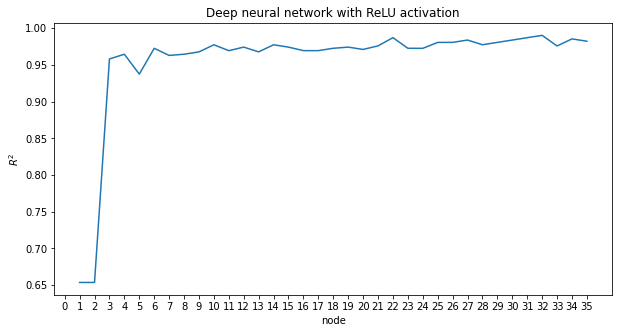

<Figure size 432x288 with 0 Axes>

In [120]:
r_squared = []
for node in range(1,36):
    r2 = nn_relu(X_train, y_train_onehot, 10, node, random_state=12)
    r_squared.append([node, r2])

r_squared = np.array(r_squared)

idx = list(range(0, 36))
plt.figure(figsize=(10, 5))
plt.plot(r_squared[:,0], r_squared[:,1])
plt.xticks(range(len(idx)),idx)
plt.xlabel('node')
plt.ylabel('$R^2$')
plt.title('Deep neural network with ReLU activation')
plt.show()
plt.clf()

In [121]:
# nn_sigmoid(X_train, y_train_onehot, 10, 30, random_state=12)
maximum = np.max(r_squared[:,1])
index_of_maximum = np.where(r_squared[:,1] == maximum)
print(index_of_maximum)
print(r_squared)
# nn_sigmoid(X_train, y_train_onehot, 10, 26, random_state=12)

(array([31]),)
[[ 1.          0.65366104]
 [ 2.          0.65366104]
 [ 3.          0.95816691]
 [ 4.          0.96461853]
 [ 5.          0.9374808 ]
 [ 6.          0.97265745]
 [ 7.          0.96300563]
 [ 8.          0.96459293]
 [ 9.          0.96779314]
 [10.          0.97747055]
 [11.          0.96945724]
 [12.          0.97429596]
 [13.          0.96781874]
 [14.          0.97749616]
 [15.          0.97429596]
 [16.          0.96950845]
 [17.          0.96950845]
 [18.          0.97270866]
 [19.          0.97429595]
 [20.          0.97112135]
 [21.          0.97596006]
 [22.          0.98714797]
 [23.          0.97273425]
 [24.          0.97263185]
 [25.          0.98069637]
 [26.          0.98074756]
 [27.          0.98392217]
 [28.          0.97752177]
 [29.          0.98074757]
 [30.          0.98392217]
 [31.          0.98714797]
 [32.          0.99032258]
 [33.          0.97588326]
 [34.          0.98550948]
 [35.          0.98233487]]


In [143]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [144]:
decision_tree_model = DecisionTreeClassifier(random_state=0, min_samples_leaf=7)

In [145]:
random_forest_model = RandomForestClassifier(random_state=0, n_estimators=41)

In [146]:
svm_polynomial_model = SVC(kernel='poly', degree=1)

In [147]:
svm_rbf_model = SVC(kernel='rbf', C=0.3)

In [148]:
data = pd.read_csv("breast-cancer-wisconsin.data", na_values="?")
# data = data.dropna()
data = data.drop('id', 1)
X = np.array(data.drop('Class', axis=1))
y = np.array(data['Class'])
y = np.where(y == 2, -1, 1)

imputer = KNNImputer(n_neighbors=1)
X = imputer.fit_transform(X)

X_train, X_val, y_train_1d, y_val_1d = train_test_split(X, y, test_size=0.1, random_state=42)

y_train = y_train_1d.reshape(-1, 1)
y_val = y_val_1d.reshape(-1, 1)

y_train_onehot = np.array(pd.get_dummies(y_train_1d))
y_val_onehot = np.array(pd.get_dummies(y_val_1d))

In [149]:
models = [knn_model, decision_tree_model, random_forest_model, svm_polynomial_model, svm_rbf_model]
final_output = []
for model in models:
    # train timer start
    start_time_train = time.time()
    model.fit(X_train, y_train_1d)
    # train timer end
    duration_train = time.time() - start_time_train
    start_time_val = time.time()
    validation_accuracy = model.score(X_val, y_val_1d)
    duration_val = time.time() - start_time_val
    final_output.append({
        'duration_train_ms': duration_train * 1000,
        'duration_val_ms': duration_val * 1000,
        'validation_accuracy': validation_accuracy
    })

In [150]:
final_output

[{'duration_train_ms': 0.9059906005859375,
  'duration_val_ms': 4.142045974731445,
  'validation_accuracy': 0.9714285714285714},
 {'duration_train_ms': 1.3279914855957031,
  'duration_val_ms': 0.3497600555419922,
  'validation_accuracy': 0.9285714285714286},
 {'duration_train_ms': 71.47598266601562,
  'duration_val_ms': 4.853010177612305,
  'validation_accuracy': 0.9571428571428572},
 {'duration_train_ms': 1.7459392547607422,
  'duration_val_ms': 0.38695335388183594,
  'validation_accuracy': 0.9714285714285714},
 {'duration_train_ms': 2.8731822967529297,
  'duration_val_ms': 0.5009174346923828,
  'validation_accuracy': 0.9571428571428572}]

In [140]:
nn_sigmoid_model = keras.Sequential(name="sigmoid_model")
nn_sigmoid_model.add(layers.Dense(21, activation="sigmoid"))
nn_sigmoid_model.add(layers.Dense(21, activation="sigmoid"))
nn_sigmoid_model.add(layers.Dense(21, activation="sigmoid"))
nn_sigmoid_model.add(layers.Dense(2, activation="softmax"))
nn_sigmoid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

nn_relu_model = keras.Sequential(name="relu_model")
nn_relu_model.add(layers.Dense(32, activation="relu"))
nn_relu_model.add(layers.Dense(32, activation="relu"))
nn_relu_model.add(layers.Dense(32, activation="relu"))
nn_relu_model.add(layers.Dense(2, activation="softmax"))
nn_relu_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [141]:
nn_models = [nn_sigmoid_model, nn_relu_model]

output = []
for model in nn_models:
    # train timer start
    start_time_train = time.time()
    model.fit(X_train, y_train_onehot, epochs=25)
    # train timer end
    duration_train = time.time() - start_time_train
    start_time_val = time.time()
    _, validation_accuracy = model.evaluate(X_val, y_val_onehot, verbose=2)
    duration_val = time.time() - start_time_val
    output.append({
        'duration_train_ms': duration_train * 1000,
        'duration_val_ms': duration_val * 1000,
        'validation_accuracy': validation_accuracy,
    })

Epoch 1/25
20/20 [==============================] - 0s 1ms/step - loss: 0.6686 - accuracy: 0.6512
Epoch 2/25
20/20 [==============================] - 0s 1ms/step - loss: 0.6186 - accuracy: 0.6712
Epoch 3/25
20/20 [==============================] - 0s 1ms/step - loss: 0.6164 - accuracy: 0.6513
Epoch 4/25
20/20 [==============================] - 0s 1ms/step - loss: 0.6006 - accuracy: 0.6454
Epoch 5/25
20/20 [==============================] - 0s 1ms/step - loss: 0.5558 - accuracy: 0.6825
Epoch 6/25
20/20 [==============================] - 0s 1ms/step - loss: 0.5455 - accuracy: 0.6419
Epoch 7/25
20/20 [==============================] - 0s 1ms/step - loss: 0.4952 - accuracy: 0.6605
Epoch 8/25
20/20 [==============================] - 0s 1ms/step - loss: 0.4584 - accuracy: 0.8450
Epoch 9/25
20/20 [==============================] - 0s 1ms/step - loss: 0.3984 - accuracy: 0.8917
Epoch 10/25
20/20 [==============================] - 0s 1ms/step - loss: 0.3264 - accuracy: 0.9437
Epoch 11/25
20/20 [

In [142]:
output

[{'duration_train_ms': 1098.5031127929688,
  'duration_val_ms': 160.55011749267578,
  'validation_accuracy': 0.9857142567634583},
 {'duration_train_ms': 1055.476188659668,
  'duration_val_ms': 144.16098594665527,
  'validation_accuracy': 0.9571428298950195}]